In [22]:
# # Check module locations if required
# import sys
# import pprint
# pprint.pprint(sys.path)

# Load Data

In [324]:
import numpy as np
import pandas as pd
import datetime as dt
import os
import codecs
import io
from lxml import etree


import seaborn as sns; sns.set(style="darkgrid")
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import re
import pickle
from tqdm.notebook import tqdm

import nltk

In [32]:
# Set display preference (Optional)
plt.rcParams["figure.figsize"] = (18,9)
plt.style.use('fivethirtyeight')

pd.options.display.max_rows = 40
pd.options.display.max_seq_items = 100
pd.set_option('display.max_colwidth', 200)

## Define Utility Functions

In [323]:
# Functions for map() or apply()

def get_word_count(x):
    '''
    Retun the number of words for the given text x.
    '''
    x = x.replace("[SECTION]", "")
    return len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', x))
        
def get_rate_change(x):
    '''
    Returns rate change decision of the FOMC Decision for the given date x.
    x should be of datetime type or yyyy-mm-dd format string.
    '''
    # If x is string, convert to datetime
    if type(x) is str:
        try:
            x = dt.datetime.strftime(x, '%Y-%m-%d')
        except:
            return None
    
    if fomc_calendar.index[0] > x or fomc_calendar.index[-1] < x:
        return None
    else:
        for idx, row in fomc_calendar.iterrows():
            if x <= idx:
                return int(row['RateDecision'])
        return None

def get_rate(x):
    '''
    Returns rate of the FOMC Decision for the given date x.
    x should be of datetime type or yyyy-mm-dd format string.
    '''
    # If x is string, convert to datetime
    if type(x) is str:
        try:
            x = dt.datetime.strftime(x, '%Y-%m-%d')
        except:
            return None
        
    if (fomc_calendar.index[0] > x) or (fomc_calendar.index[-1] < x):
        return None
    else:
        for idx, row in fomc_calendar.iterrows():
            if x <= idx:
                return float(row['Rate'])
        return None

def get_fomc_meeting_date(x):
    '''
    Returns fomc meeting date for the given date x, referring to fomc_calendar DataFrame.
    x should be of datetime type or yyyy-mm-dd format string.
    '''
    # If x is string, convert to datetime
    if type(x) is str:
        try:
            x = dt.datetime.strftime(x, '%Y-%m-%d')
        except:
            return None
        
    if fomc_calendar.index[0] > x:
        return None
    else:
        for i in range(len(fomc_calendar)):
            if x <= fomc_calendar.index[i]:
                return fomc_calendar.index[i]
        return None

In [325]:
def remove_short_section(df, min_words=50):
    '''
    Using 'text_sections' of the given dataframe, remove sections having less than min_words.
    It concatinate sections with a space, which exceeds min_words and update 'text'.
    As a fallback, keep a text which concatinates sections having more than 20 words and use it
     if there is no section having more than min_words.
    If there is no sections having more than 20 words, do not update 'text'.
    '''
    new_df = df.copy()
    new_text_list = []
    new_wc_list = []
    
    for i, row in tqdm(new_df.iterrows()):
        new_text = ""
        bk_text = ""
                
        for section in row['text_sections']:
            num_words = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', section))
            if num_words > min_words:
                new_text += " " + section
            elif num_words > 20:
                bk_text += " " + section
        
        new_text = new_text.strip()
        bk_text = bk_text.strip()
        
        if len(new_text) > 0:
            new_text_list.append(new_text)
        elif len(bk_text) > 0:
            new_text_list.append(bk_text) # Fall back    
        else:
            new_text_list.append(row['text'])
        
        # Update the word count
        new_wc_list.append(len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', new_text_list[-1])))
        
    new_df['text'] = new_text_list
    new_df['word_count'] = new_wc_list
    
    return new_df

# Keep only those having key words and longer than a certain length
def remove_short_nokeyword(df, min_keyword=2, min_word=50):
    num_keep, num_drop_short, num_drop_no_kw = 0, 0, 0
    keywords = ['rate', 'rates']
    print('Before len(df): ', len(df))
    for i, row in tqdm(df.iterrows(), desc='Looping Speech DataFrame'):
        new_text = ''
        text_list = row["text"].split("\n\n[SECTION]\n\n")
        for text in text_list:
            text_words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text)
            if len(text_words) < 50:
                num_drop_short += 1
            elif len(set(text_words).intersection(keywords)) < min_keyword:
                num_drop_no_kw += 1
            else:
                new_text += '\n\n' + text
                num_keep += 1
        if new_text == '':
            df.drop([i], axis=0, inplace=True)
        else:
            df.loc[i, 'text'] = new_text
    print("Kept: {}, Dropped (too short): {}, Dropped (no keywords): {}".format(num_keep, num_drop_short, num_drop_no_kw))
    print('After len(df): ', len(df))

In [355]:
# Split functions to process long text in machine learning based NLP

def get_split(text, split_len=200, overlap=50):
    '''
    Returns a list of split text of $split_len with overlapping of $overlap.
    Each item of the list will have around split_len length of text.
    '''
    l_total = []
    words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text)
    
    if len(words) < split_len:
        n = 1
    else:
        n = (len(words) - overlap) // (split_len - overlap) + 1
        
    for i in range(n):
        l_parcial = words[(split_len - overlap) * i: (split_len - overlap) * i + split_len]
        l_total.append(" ".join(l_parcial))
    return l_total

def get_split_df(df, split_len=200, overlap=50):
    '''
    Returns a dataframe which is an extension of an input dataframe.
    Each row in the new dataframe has less than $split_len words in 'text'.
    '''
    split_data_list = []

    for i, row in tqdm(df.iterrows(), desc='Looping dataframe'):
        #print("Original Word Count: ", row['word_count'])
        text_list = get_split(row["text"], split_len, overlap)
        for text in text_list:
            row['text'] = text
            #print(len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text)))
            row['word_count'] = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text))
            split_data_list.append(list(row))
            
    split_df = pd.DataFrame(split_data_list, columns=df.columns)
    return split_df

In [341]:
def one_hot_encode(df):
    df['target_lower'] = df['target'].apply(lambda x: 1 if x == 0 else 0)
    df['target_hold'] = df['target'].apply(lambda x: 1 if x == 1 else 0)
    df['target_raise'] = df['target'].apply(lambda x: 1 if x == 2 else 0)


## Load Text
### Statement

In [33]:
file = open('../data/FOMC/statement.pickle', 'rb')

statement_df = pickle.load(file)
file.close()

print(statement_df.shape)
statement_df

(196, 4)


,date,contents,speaker,title
0,1994-02-04,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to ...,Alan Greenspan,FOMC Statement
1,1994-03-22,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to...,Alan Greenspan,FOMC Statement
2,1994-04-18,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with ...,Alan Greenspan,FOMC Statement
3,1994-05-17,\n\n[SECTION]\n\nThe Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.\n\n[SECTION]\n\nThe Board approved a...,Alan Greenspan,FOMC Statement
4,1994-08-16,\n\n[SECTION]\n\nThe Federal Reserve announced today the following monetary policy actions:\n\n[SECTION]\n\nThese measures were taken against the background of evidence of continuing strength in t...,Alan Greenspan,FOMC Statement
5,1994-11-15,"\n\n[SECTION]\n\nThe Federal Reserve Board today approved an increase in the discount rate from 4 percent to 4 3/4 percent, effective immediately.\n\n[SECTION]\n\nIn a related move, the Federal Op...",Alan Greenspan,FOMC Statement
6,1995-02-01,"\n\n[SECTION]\n\nFor immediate release\n\n[SECTION]\n\nThe Federal Reserve Board today approved an increase in the discount rate from 4 3/4 percent to 5 1/4 percent, effective immediately.\n\n[SEC...",Alan Greenspan,FOMC Statement
7,1995-07-06,\n\n[SECTION]\n\nFor immediate release\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to decrease slightly the degree of pressure on bank re...,Alan Greenspan,FOMC Statement
8,1995-12-19,\n\n[SECTION]\n\nFor immediate release\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to decrease slightly the degree of pressure on reserve...,Alan Greenspan,FOMC Statement
9,1996-01-31,For immediate release\n\n\n\n\n\n\r\n\r\nThe Federal Reserve today announced the following policy \r\nactions:\r\n\r\n\nThe Board of Governors approved a reduction in the discount rate from \r\n5-...,Alan Greenspan,FOMC Statement


In [51]:
# Sample Contents - the 2nd last
print(statement_df['contents'].iloc[-1])

The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.

[SECTION]

Federal Open Market Committee

[SECTION]

Monetary Policy Principles and Practice

[SECTION]

Policy Implementation

[SECTION]

Reports

[SECTION]

Review of Monetary Policy Strategy, Tools, and Communications

[SECTION]

Institution Supervision

[SECTION]

Reports

[SECTION]

Reporting Forms

[SECTION]

Supervision & Regulation Letters

[SECTION]

Banking Applications & Legal Developments

[SECTION]

Regulatory Resources

[SECTION]

Banking & Data Structure

[SECTION]

Regulations & Statutes

[SECTION]

Payment Policies

[SECTION]

Reserve Bank Payment Services & Data

[SECTION]

Financial Market Utilities & Infrastructures

[SECTION]

Research, Committees, and Forums

[SECTION]

Working Papers and Notes

[SECTION]

Models and Tools

[SECTION]

Bank Assets and Liabilities

[SECTION]

Bank Structure Data

[SECTION]

Business Financ

### Meeting Minutes

In [45]:
file = open('../data/FOMC/minutes.pickle', 'rb')

minutes_df = pickle.load(file)
file.close()

print(minutes_df.shape)
minutes_df

(226, 4)


,date,contents,speaker,title
0,1993-02-03,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, February 2, 1993, at...",Alan Greenspan,FOMC Meeting Minutes
1,1993-03-23,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, March 23, 1993, a...",Alan Greenspan,FOMC Meeting Minutes
2,1993-05-18,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, May 18, 1993, at ...",Alan Greenspan,FOMC Meeting Minutes
3,1993-07-07,"A meeting of the Federal Open Market Committee was held in the \r\n offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, July 6, 1993, at 2:3...",Alan Greenspan,FOMC Meeting Minutes
4,1993-08-17,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, August 17, 1993, at ...",Alan Greenspan,FOMC Meeting Minutes
5,1993-09-21,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, September 21, 1993, ...",Alan Greenspan,FOMC Meeting Minutes
6,1993-11-16,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, November 16, 1993, a...",Alan Greenspan,FOMC Meeting Minutes
7,1993-12-21,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, December 21, 1993, at 9:...",Alan Greenspan,FOMC Meeting Minutes
8,1994-02-04,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Thursday, February 3, 1994, a...",Alan Greenspan,FOMC Meeting Minutes
9,1994-03-22,"A meeting of the Federal Open Market Committee was held in \n the offices of the Board of Governors of the Federal Reserve System in \n Washington, D.C., on Tuesday, March 22, 1994, at 9:00 a.m....",Alan Greenspan,FOMC Meeting Minutes


In [52]:
# Sample Contents - the 2nd last
print(minutes_df['contents'].iloc[-1])

The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.

[SECTION]

Federal Open Market Committee

[SECTION]

Monetary Policy Principles and Practice

[SECTION]

Policy Implementation

[SECTION]

Reports

[SECTION]

Review of Monetary Policy Strategy, Tools, and Communications

[SECTION]

Institution Supervision

[SECTION]

Reports

[SECTION]

Reporting Forms

[SECTION]

Supervision & Regulation Letters

[SECTION]

Banking Applications & Legal Developments

[SECTION]

Regulatory Resources

[SECTION]

Banking & Data Structure

[SECTION]

Regulations & Statutes

[SECTION]

Payment Policies

[SECTION]

Reserve Bank Payment Services & Data

[SECTION]

Financial Market Utilities & Infrastructures

[SECTION]

Research, Committees, and Forums

[SECTION]

Working Papers and Notes

[SECTION]

Models and Tools

[SECTION]

Bank Assets and Liabilities

[SECTION]

Bank Structure Data

[SECTION]

Business Financ

### Meeting Transcripts

In [41]:
file = open('../data/FOMC/meeting_script.pickle', 'rb')

meeting_script_df = pickle.load(file)
file.close()

print(meeting_script_df.shape)
meeting_script_df

(200, 4)


,date,contents,speaker,title
0,1990-02-07,MESSRS. CROSS & STERNLIGHT. [Statements--see Appendix.]\n\n[SECTION]\n\nMESSRS. PRELL & TRUMAN. [Statements--see Appendix.]\n\n[SECTION]\n\nCHAIRMAN GREENSPAN. Questions for the gentleme...,Alan Greenspan,FOMC Meeting Transcript
1,1990-03-27,CHAIRMAN GREENSPAN. Governor LaWare has moved that it is agood morning. Are there any seconds?\n\n[SECTION]\n\nMR. JOHNSON. Second.\n\n[SECTION]\n\nSPEAKER(?). It's too early to ...,Alan Greenspan,FOMC Meeting Transcript
2,1990-05-15,CHAIRMAN GREENSPAN. Will someone move approval of theminutes of the March 27th meeting?\n\n[SECTION]\n\nMS. SEGER. I'll move them.\n\n[SECTION]\n\nMR. KELLEY. Second.\n\n[SECTION]\n\...,Alan Greenspan,FOMC Meeting Transcript
3,1990-07-03,"CHAIRMAN GREENSPAN. Can we get started, please? If somebodywould like to move approval of the minutes--\n\n[SECTION]\n\nVICE CHAIRMAN CORRIGAN. So move.\n\n[SECTION]\n\nSPEAKER(?). ...",Alan Greenspan,FOMC Meeting Transcript
4,1990-08-21,"CHAIRMAN GREENSPAN. Good morning, everyone. We'll startwith a controversial issue: approval of the minutes.\n\n[SECTION]\n\nSPEAKER(?). So move.\n\n[SECTION]\n\nCHAIRMAN GREENSPAN. ...",Alan Greenspan,FOMC Meeting Transcript
5,1990-10-02,"CHAIRMAN GREENSPAN. Good morning, everyone. Would somebodykindly move the minutes of the last FOMC meeting?\n\n[SECTION]\n\nMS. SEGER. I'll move.\n\n[SECTION]\n\nCHAIRMAN GREENSPAN. Is ...",Alan Greenspan,FOMC Meeting Transcript
6,1990-11-13,CHAIRMAN GREENSPAN. Would somebody like to move approval ofthe minutes?\n\n[SECTION]\n\nMS. SEGER. I'll move.\n\n[SECTION]\n\nSPEAKER(?). Second.\n\n[SECTION]\n\nCHAIRMAN GREENSPAN. No...,Alan Greenspan,FOMC Meeting Transcript
7,1990-12-18,CHAIRMAN GREENSPAN. Would somebody like to move the minutesof the previous meeting?\n\n[SECTION]\n\nVICE CHAIRMAN CORRIGAN. So move.\n\n[SECTION]\n\nMR. SYRON. Second.\n\n[SECTION]\...,Alan Greenspan,FOMC Meeting Transcript
8,1991-02-06,"CHAIRMAN GREENSPAN. Good afternoon, everyone. Welcome, BobMcTeer; it's nice to see you at the table. You're sitting between twoformidable characters but I suspect you'll surviv...",Alan Greenspan,FOMC Meeting Transcript
9,1991-03-26,"CHAIRMAN GREENSPAN. This is the first time in a long timethat [the Committee membership] has been addressed as ""Messrs."" Whowould like to move approval of the minutes?\n\n[SECTIO...",Alan Greenspan,FOMC Meeting Transcript


In [53]:
# Sample Contents - the 2nd last
print(meeting_script_df['contents'].iloc[-1])

CHAIR YELLEN.  Good afternoon, everyone.  I think we are ready to begin.  The first item we are going to consider is in a joint Board and FOMC meeting, so I need a motion to close the Board meeting. 

[SECTION]

MR. FISCHER.  So moved. 

[SECTION]

CHAIR YELLEN.  Without objection, thank you.  I’m going to start off by calling on Simon to give us his report on market developments. 

[SECTION]

MR. POTTER.1  Thank you, Madam Chair.  Lorie and I will be splitting the Desk briefing into two parts.  I will discuss financial market developments and some issues related to open market operations.  After questions and answers on this section, Lorie will discuss testing and some related issues with supplementary normalization tools. Over the intermeeting period, U.S. economic data were generally viewed as positive and changes in financial conditions were mixed.  International developments were in focus with more-accommodative policy adopted or communicated by major central banks, driven by conc

### Press Conference Transcripts

In [55]:
file = open('../data/FOMC/presconf_script.pickle', 'rb')

presconf_script_df = pickle.load(file)
file.close()

print(presconf_script_df.shape)
presconf_script_df

(43, 4)


,date,contents,speaker,title
0,2011-04-27,"CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl...",Ben Bernanke,FOMC Press Conference Transcript
1,2011-06-22,"CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks today, I’ll briefly review today’s policy decision. And I’ll place the decision in the context of our economic projections ...",Ben Bernanke,FOMC Press Conference Transcript
2,2011-11-02,"CHAIRMAN BERNANKE. Good afternoon, everybody. Welcome. In my opening remarks, I will briefly review today’s policy decision of the Federal Open our policy strategy. I will then be glad to take...",Ben Bernanke,FOMC Press Conference Transcript
3,2012-01-25,CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks I will briefly review today’s policy decision by the Federal Open to you regarding the Committee’s longer-run policy goals a...,Ben Bernanke,FOMC Press Conference Transcript
4,2012-04-25,"CHAIRMAN BERNANKE. Good afternoon. Before we get to questions, I’ll summarize today’s policy action by the Federal Open Market Committee and then I’ll place the Committee’s policy decision in th...",Ben Bernanke,FOMC Press Conference Transcript
5,2012-06-20,"CHAIRMAN BERNANKE. Good afternoon. Before we get to questions, I’ll summarize today’s policy action by the Federal Open Market Committee and then place the Committee’s appropriate path of moneta...",Ben Bernanke,FOMC Press Conference Transcript
6,2012-09-13,CHAIRMAN BERNANKE. Good afternoon. Earlier today the Federal Open Market Committee (FOMC) approved new measures to support the recovery and employment growth. I’ll get to the specifics of our a...,Ben Bernanke,FOMC Press Conference Transcript
7,2012-12-12,"CHAIRMAN BERNANKE. Good afternoon. It’s been about three and a half years since the economic recovery began. The economy continues to expand at a moderate pace. Unfortunately, however, unemplo...",Ben Bernanke,FOMC Press Conference Transcript
8,2013-03-20,"CHAIRMAN BERNANKE. Good afternoon. The Federal Open Market Committee concluded a two-day meeting earlier today. As always, my colleagues and I reviewed recent economic and financial developmen...",Ben Bernanke,FOMC Press Conference Transcript
9,2013-06-19,"CHAIRMAN BERNANKE. Good afternoon. The Federal Open Market Committee concluded a two-day meeting earlier today. Based on its review of recent economic and financial developments, the Committee...",Ben Bernanke,FOMC Press Conference Transcript


In [57]:
# Sample Contents - the 2nd last
print(presconf_script_df['contents'].iloc[-1])

CHAIR POWELL.  Good afternoon.  Thanks for joining us today.  I would like to begin by acknowledging the tragic loss and tremendous hardship that people are experiencing both here in the United States and around the world.  The coronavirus outbreak is first and foremost a public health crisis, and the most important response is coming from those in the front lines in hospitals, emergency services, and care facilities.  On behalf of the Federal Reserve, let me express our sincere gratitude to those dedicated individuals who put themselves at risk, day after day, in service to others and to our nation. The forceful measures that we as a country are taking to control the spread of the virus have brought much of the economy to an abrupt halt.  Many businesses have closed, people have been asked to stay home, and basic social interactions are greatly curtailed.  People are putting their lives and livelihoods on hold, at significant economic and personal cost.  All of us are affected, but th

### Speech

In [40]:
file = open('../data/FOMC/speech.pickle', 'rb')

speech_df = pickle.load(file)
file.close()

print(speech_df.shape)
speech_df

(1461, 4)


,date,contents,speaker,title
0,1996-06-13,"Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\...",Chairman Alan Greenspan,Bank supervision in a world economy
1,1996-06-18,"Remarks by Governor Edward W. Kelley, Jr.\nDevelopments in electronic money and banking\r\nAt the CyberPayments '96 Conference, Dallas, Texas\r\nJune 18, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nIt i...","Governor Edward W. Kelley, Jr.",Developments in electronic money and banking
2,1996-09-08,Monetary Policy Objectives and Strategy\n\n[SECTION]\n\nI want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I al...,Governor Laurence H. Meyer,Monetary policy objectives and strategy
3,1996-09-19,"Remarks by Chairman Alan Greenspan\nRegulation of electronic payment systems\r\nAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC \r\nSeptember 1...",Chairman Alan Greenspan,Regulation and electronic payment systems
4,1996-10-02,"Remarks by Governor Lawrence B. Lindsey\r\nAt the Small Business Development Conference, Richmond, Virginia\r\nOctober 2, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nSmall Business Is Big Business\n\n[S...",Governor Lawrence B. Lindsey,Small business is big business
5,1996-10-05,"Remarks by Chairman Alan Greenspan\nBank supervision, regulation, and risk\r\nAt the Annual Convention of the American Bankers Association, Honolulu, Hawaii \r\nOctober 5, 1996\n\n[SECTION]\n\n\n\...",Chairman Alan Greenspan,"Bank supervision, regulation, and risk"
6,1996-10-07,"Remarks by Chairman Alan Greenspan\nU.S. Treasury securities market: Lessons from Alexander Hamilton\r\nAt the Annual Public Service Awards Dinner of the Public Securities Association, New York, N...",Chairman Alan Greenspan,U.S. Treasury securities market: Lessons from Alexander Hamilton
7,1996-10-09,"Remarks by Governor Lawrence B. Lindsey\r\nAt the Community Development Lending Conference, Dallas, Texas\r\nOctober 9, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nHere We Go Again?\n\n[SECTION]\n\nThan...",Governor Lawrence B. Lindsey,Here we go again?
8,1996-10-11,"Remarks by Governor Lawrence B. Lindsey\r\nAt the Atlantic Economic Society, Washington, D.C.\r\nOctober 11, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nHow To Grow Faster\n\n[SECTION]\n\nIt is my pleas...",Governor Lawrence B. Lindsey,How to grow faster
9,1996-10-16,"Remarks by Chairman Alan Greenspan\nTechnological advances and productivity\r\nAt the 80th Anniversary Awards Dinner of The Conference Board, New York, New York\r\nOctober 16, 1996\n\n[SECTION]\n\...",Chairman Alan Greenspan,Technological advances and productivity


In [58]:
# Sample Contents - the 2nd last
print(speech_df['contents'].iloc[-1])

The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.

[SECTION]

Federal Open Market Committee

[SECTION]

Monetary Policy Principles and Practice

[SECTION]

Policy Implementation

[SECTION]

Reports

[SECTION]

Review of Monetary Policy Strategy, Tools, and Communications

[SECTION]

Institution Supervision

[SECTION]

Reports

[SECTION]

Reporting Forms

[SECTION]

Supervision & Regulation Letters

[SECTION]

Banking Applications & Legal Developments

[SECTION]

Regulatory Resources

[SECTION]

Banking & Data Structure

[SECTION]

Regulations & Statutes

[SECTION]

Payment Policies

[SECTION]

Reserve Bank Payment Services & Data

[SECTION]

Financial Market Utilities & Infrastructures

[SECTION]

Research, Committees, and Forums

[SECTION]

Working Papers and Notes

[SECTION]

Models and Tools

[SECTION]

Bank Assets and Liabilities

[SECTION]

Bank Structure Data

[SECTION]

Business Financ

### Testimony

In [43]:
file = open('../data/FOMC/testimony.pickle', 'rb')

testimony_df = pickle.load(file)
file.close()

print(testimony_df.shape)
testimony_df

(436, 4)


,date,contents,speaker,title
0,1996-06-26,\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nIt is a pleasure to appear before this Subcommittee to discuss\r\n\r\n the supervision of bank sales practices on behalf of ...,"Governor Edward W. Kelley, Jr.",Supervision of bank sales practices
1,1996-07-17,"\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI am pleased to appear before the Committee on Banking, Housing,\r\n\r\n and Urban Affairs to discuss actions that the Feder...","Herbert A. Biern, Deputy Associate Director, Division of Banking Supervision and Regulation","""Prime bank"" schemes"
2,1996-07-18,"Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 18, 1996\n\n[SECT...",Chairman Alan Greenspan,The Federal Reserve's semiannual monetary report
3,1996-07-24,\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI am pleased to appear before this Subcommittee today to discuss trends\r\n\r\nin consumer lending and the Federal Reserve Board...,Governor Janet L. Yellen,Trends in consumer lending
4,1996-07-26,\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI appreciate this opportunity to appear before the Banking Committee\r\n\r\ntoday to address certain recent reports on the Feder...,Chairman Alan Greenspan,Recent reports on Federal Reserve operations
5,1996-09-12,"\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI am pleased to appear before this Committee today to discuss trends in consumer\r\n\r\nlending, the Federal Reserve Board's vie...",Governor Lawrence B. Lindsey,Trends in consumer lending
6,1996-09-18,\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nThank you for the opportunity to discuss the recent trading losses by Sumitomo Corporation and their implications for U.S. banks and markets. T...,Governor Susan M. Phillips,Implications of trading losses by Sumitomo Corp.
7,1997-01-21,"Testimony of Chairman Alan Greenspan\nPerformance of the U.S. economy\r\nBefore the Committee on the Budget, United States Senate\r\nJanuary 21, 1997\n\n[SECTION]\n\nMr. Chairman and members of th...",Chairman Alan Greenspan,"January 21, 1997"
8,1997-01-30,"Testimony of Chairman Alan Greenspan\nThe consumer price index\r\nBefore the Committee on Finance, United States Senate\r\nJanuary 30, 1997\n\n[SECTION]\n\nMr. Chairman and members of the Committe...",Chairman Alan Greenspan,The comsumer price index
9,1997-02-13,Testimony of Chairman Alan Greenspan\nModernization of the financial system\r\nBefore the Subcommittee on Financial Institutions and Consumer Credit\r\n\tof the Committee on Banking and Financial ...,Chairman Alan Greenspan,Modernization of the financial system


In [59]:
# Sample Contents - the 2nd last
print(testimony_df['contents'].iloc[-1])

The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.

[SECTION]

Federal Open Market Committee

[SECTION]

Monetary Policy Principles and Practice

[SECTION]

Policy Implementation

[SECTION]

Reports

[SECTION]

Review of Monetary Policy Strategy, Tools, and Communications

[SECTION]

Institution Supervision

[SECTION]

Reports

[SECTION]

Reporting Forms

[SECTION]

Supervision & Regulation Letters

[SECTION]

Banking Applications & Legal Developments

[SECTION]

Regulatory Resources

[SECTION]

Banking & Data Structure

[SECTION]

Regulations & Statutes

[SECTION]

Payment Policies

[SECTION]

Reserve Bank Payment Services & Data

[SECTION]

Financial Market Utilities & Infrastructures

[SECTION]

Research, Committees, and Forums

[SECTION]

Working Papers and Notes

[SECTION]

Models and Tools

[SECTION]

Bank Assets and Liabilities

[SECTION]

Bank Structure Data

[SECTION]

Business Financ

## Load Market Data

### Target FED Rate

First tried to retrieve from contents, but it was not always accurate.
Thus, load historical FED Rate and match by the dates

Downloaded from FRB of New York (https://apps.newyorkfed.org/markets/autorates/fed%20funds)

In [89]:
# Load FED Target Rates
filename = '../data/MarketData/FEDRates/ffs-01172000-02092020.csv'

fedrates = pd.read_csv(filename, header=0, names=('Date', 'Vol', 'EFFR', '1st','25th' ,'75th' ,'99th' ,'Target' ,'Low' ,'High','Std.' ))
fedrates.index = pd.to_datetime(fedrates.Date, format="%d/%m/%Y")
fedrates.dropna(inplace=True, axis=0, subset=['Date', 'Target'])
fedrates.drop(columns=['Date', 'Vol', 'EFFR', '1st','25th' ,'75th' ,'99th','Low' ,'High','Std.'], inplace=True)

# Separate Range to Low and High
fedrates['Low'] = None
fedrates['High'] = None

for i in range(fedrates.shape[0]):
    target = fedrates['Target'][i]
    if '-' in target:
        fedrates['Low'][i] = re.findall(r'([0-9.]+)-', target)[0]
        fedrates['High'][i] = re.findall(r'-([0-9.]+)', target)[0]
    else:
        (fedrates['Low'][i], fedrates['High'][i]) = (target, target)

fedrates

,Target,Low,High
Date,,,
2020-02-06,1.50-1.75,1.50,1.75
2020-02-05,1.50-1.75,1.50,1.75
2020-02-04,1.50-1.75,1.50,1.75
2020-02-03,1.50-1.75,1.50,1.75
2020-01-31,1.50-1.75,1.50,1.75
2020-01-30,1.50-1.75,1.50,1.75
2020-01-29,1.50-1.75,1.50,1.75
2020-01-28,1.50-1.75,1.50,1.75
2020-01-27,1.50-1.75,1.50,1.75


In [90]:
fedrates.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4925 entries, 2020-02-06 to 2000-07-03
Data columns (total 3 columns):
Target    4925 non-null object
Low       4925 non-null object
High      4925 non-null object
dtypes: object(3)
memory usage: 313.9+ KB


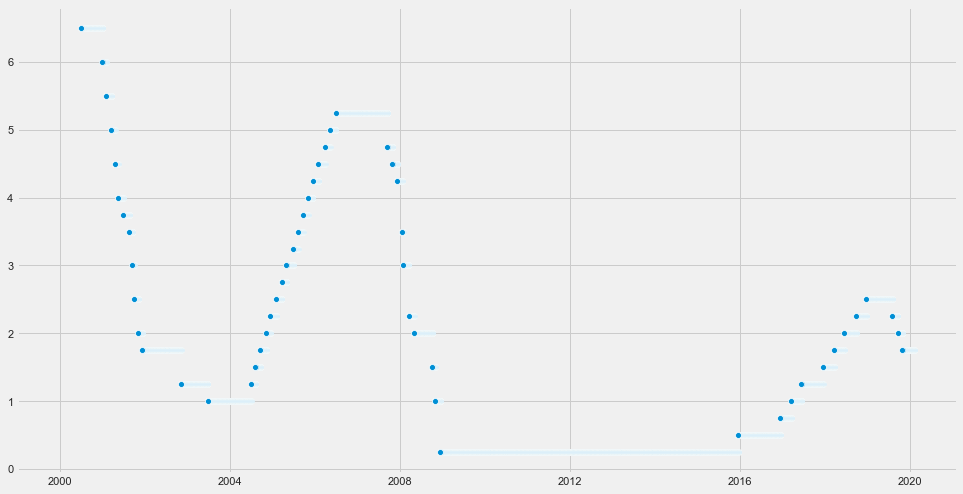

In [91]:
plt.figure(figsize=(15,8))
ax = sns.scatterplot(data=(fedrates["High"].apply(lambda x: float(x))))

Looks good, but FRB of New York has historical data only from 2000.

So, download from FRB of St. Louis 
(https://fred.stlouisfed.org/searchresults?nasw=0&st=FED%20Rate&t=rate%3Bfederal%3Binterest%20rate&ob=sr&od=desc&types=gen).

Download the following three files in csv:

 * Federal Funds Target Range - Upper Limit
 * Federal Funds Target Range - Lower Limit
 * Federal Funds Target Rate (DISCONTINUED)

In [19]:
# FRB changed to range from 2008. So use Upper side from 2008.
filename_till08 = '../data/MarketData/FEDRates/DFEDTAR.csv'
filename_from08u = '../data/MarketData/FEDRates/DFEDTARU.csv'
filename_from08l = '../data/MarketData/FEDRates/DFEDTARL.csv'

fedtar = pd.read_csv(filename_till08, names=['Date', 'Rate'], header=0)
fedtaru = pd.read_csv(filename_from08u, names=['Date', 'Rate'], header=0)
fedtarl = pd.read_csv(filename_from08l, names=['Date', 'Rate'], header=0)
fedrate_df = pd.concat([fedtar, fedtaru], axis=0)
fedrate_df.index = pd.to_datetime(fedrate_df.Date, format="%Y-%m-%d")
fedrate_df.drop(columns=['Date'], inplace=True)
fedrate_df['Rate'] = fedrate_df['Rate'].map(lambda x: np.float(x))
fedrate_df

,Rate
Date,
1982-09-27,10.250
1982-09-28,10.250
1982-09-29,10.250
1982-09-30,10.250
1982-10-01,10.000
1982-10-02,10.000
1982-10-03,10.000
1982-10-04,10.000
1982-10-05,10.000


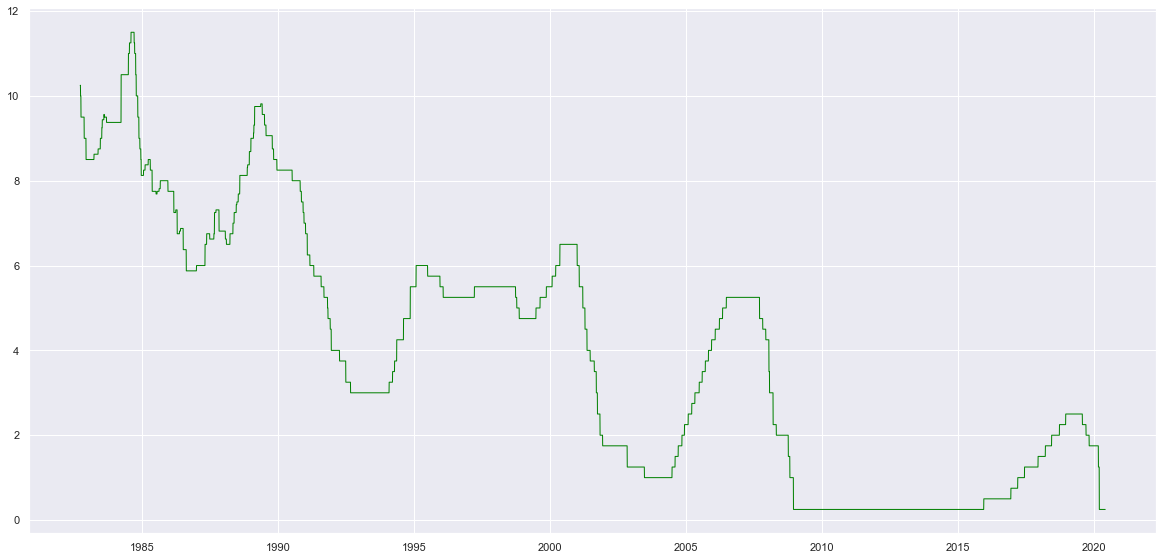

In [92]:
fig, ax = plt.subplots()
ax.plot(fedrate_df.index, fedrate_df['Rate'].values, 
         c = 'green',
         linewidth= 1.0)
ax.grid(True)
plt.show()

In [21]:
fedtaru.tail(300)

,Date,Rate
3888,2019-08-09,2.25
3889,2019-08-10,2.25
3890,2019-08-11,2.25
3891,2019-08-12,2.25
3892,2019-08-13,2.25
3893,2019-08-14,2.25
3894,2019-08-15,2.25
3895,2019-08-16,2.25
3896,2019-08-17,2.25
3897,2019-08-18,2.25


### Effective FED Rate

In [113]:
# Load Real GDP
# Billions of Chained 2012 Dollars, Seasonally Adjusted Annual Rate

filename = '../data/MarketData/FEDRates/DFF.csv'

dff = pd.read_csv(filename, header=0)
dff

,DATE,DFF
0,1954-07-01,1.13
1,1954-07-02,1.25
2,1954-07-03,1.25
3,1954-07-04,1.25
4,1954-07-05,0.88
5,1954-07-06,0.25
6,1954-07-07,1.00
7,1954-07-08,1.25
8,1954-07-09,1.25
9,1954-07-10,1.25


(803, 2)


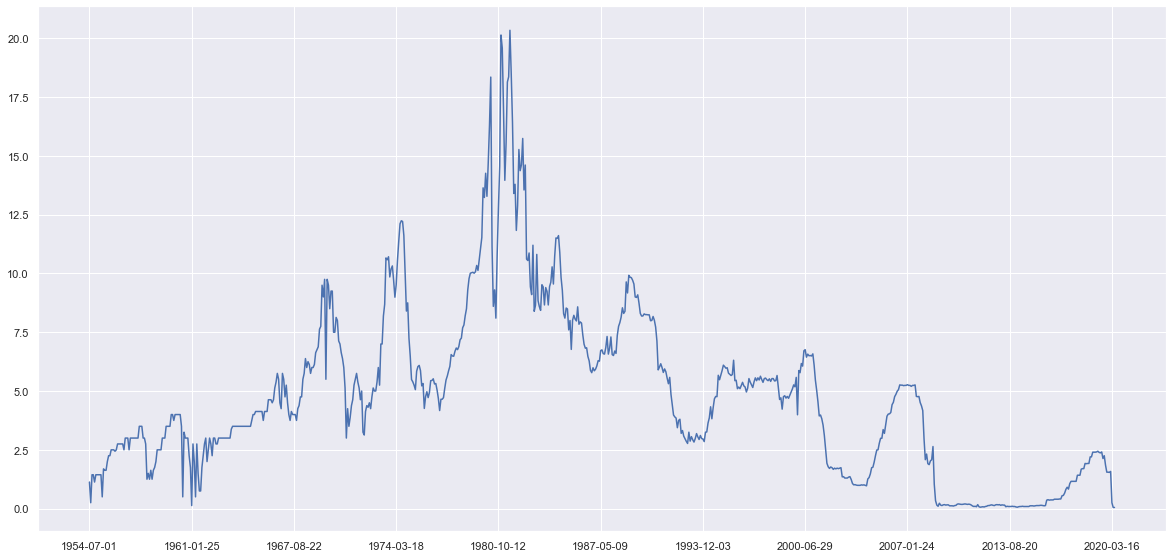

In [120]:
# Use every 30th row as it has too many data points
dff_30 = dff.iloc[::30, :]
print(dff_30.shape)

fig, ax = plt.subplots()
ax.plot(dff_30['DATE'], dff_30['DFF'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(80))
plt.show()

### GDP

Real GDP, Quarterly announced

In [60]:
# Load Real GDP
# Billions of Chained 2012 Dollars, Seasonally Adjusted Annual Rate

filename = '../data/MarketData/GDP/GDPC1.csv'

gdpc1 = pd.read_csv(filename, header=0)
gdpc1

,DATE,GDPC1
0,1947-01-01,2033.061
1,1947-04-01,2027.639
2,1947-07-01,2023.452
3,1947-10-01,2055.103
4,1948-01-01,2086.017
5,1948-04-01,2120.450
6,1948-07-01,2132.598
7,1948-10-01,2134.981
8,1949-01-01,2105.562
9,1949-04-01,2098.380


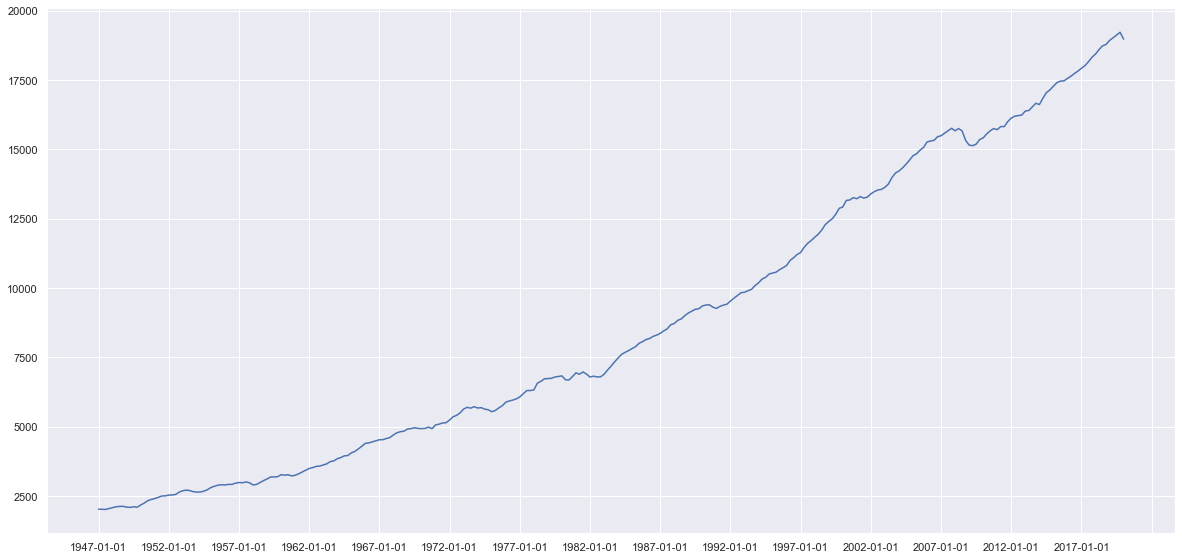

In [99]:
fig, ax = plt.subplots()
ax.plot(gdpc1['DATE'], gdpc1['GDPC1'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
plt.show()

In [61]:
# Load Read Potential GDP
# Billions of Chained 2012 Dollars, Not Seasonally Adjusted

filename = '../data/MarketData/GDP/GDPPOT.csv'

gdppot = pd.read_csv(filename, header=0)
gdppot

,DATE,GDPPOT
0,1949-01-01,2105.424751
1,1949-04-01,2133.335241
2,1949-07-01,2162.374385
3,1949-10-01,2190.094474
4,1950-01-01,2219.369859
5,1950-04-01,2249.002234
6,1950-07-01,2278.748686
7,1950-10-01,2309.863306
8,1951-01-01,2341.614907
9,1951-04-01,2373.371288


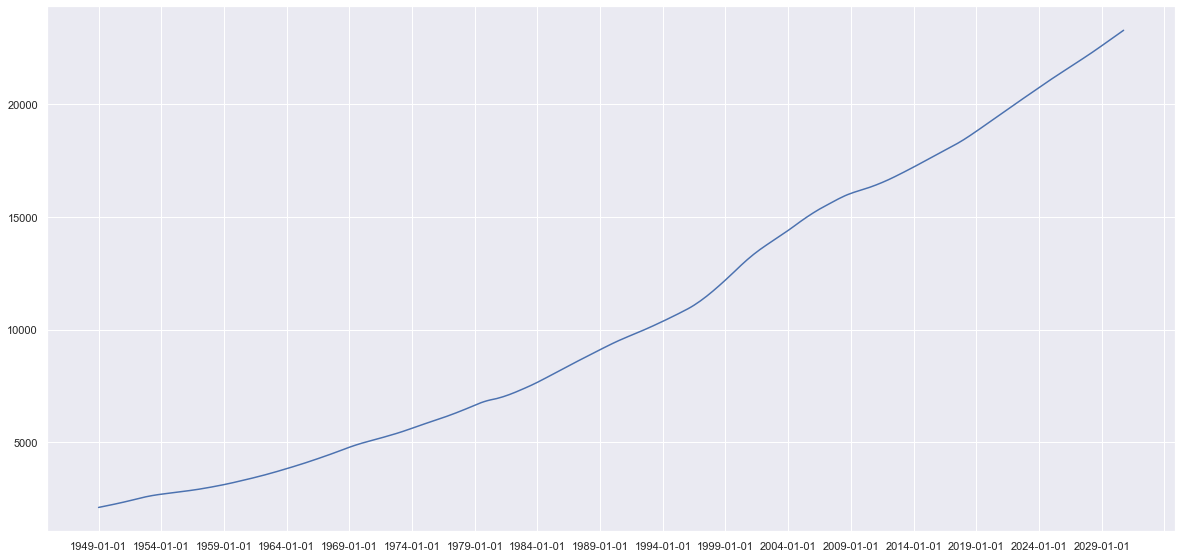

In [101]:
fig, ax = plt.subplots()
ax.plot(gdppot['DATE'], gdppot['GDPPOT'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
plt.show()

### CPI

Use Core Consumer Price Index excluding Food and Energy as FRB takes this index as important indicator
It is announced monthly around 10th of each month for the previous month.

In [64]:
# Load Personal Consumption Expenditures Excluding Food and Energy (Chain-Type Price Index)
# Index 2012=100, Seasonally Adjusted

filename = '../data/MarketData/CPI/PCEPILFE.csv'

pcepilfe = pd.read_csv(filename, header=0)
pcepilfe

,DATE,PCEPILFE
0,1959-01-01,16.727
1,1959-02-01,16.740
2,1959-03-01,16.759
3,1959-04-01,16.801
4,1959-05-01,16.822
5,1959-06-01,16.871
6,1959-07-01,16.911
7,1959-08-01,16.938
8,1959-09-01,16.983
9,1959-10-01,17.012


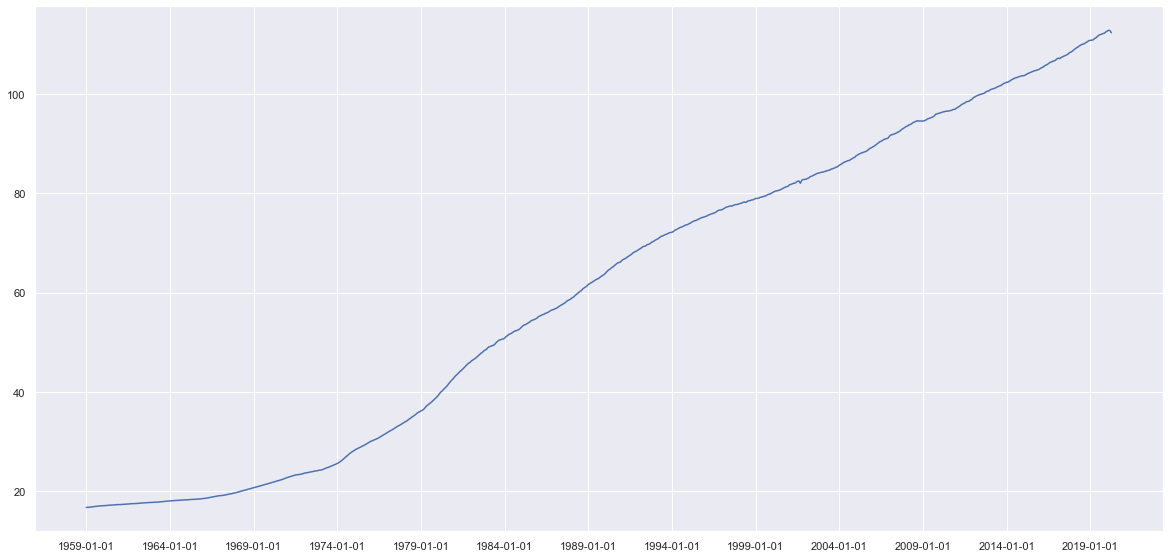

In [104]:
fig, ax = plt.subplots()
ax.plot(pcepilfe['DATE'], pcepilfe['PCEPILFE'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(60))
plt.show()

### Unemployment

Takes unemployment rate as important input for FRB's decision. Real Potential GDP is quarterly and usually two month after each quarter. On the other hand, unemployment is annnounced monthly, around a week after the end of each month and can be more real-time.

In [63]:
# Load Unemployment
# Percent, Seasonally Adjusted

filename = '../data/MarketData/Unemployment/UNRATE.csv'

unrate = pd.read_csv(filename, header=0)
unrate

,DATE,UNRATE
0,1948-01-01,3.4
1,1948-02-01,3.8
2,1948-03-01,4.0
3,1948-04-01,3.9
4,1948-05-01,3.5
5,1948-06-01,3.6
6,1948-07-01,3.6
7,1948-08-01,3.9
8,1948-09-01,3.8
9,1948-10-01,3.7


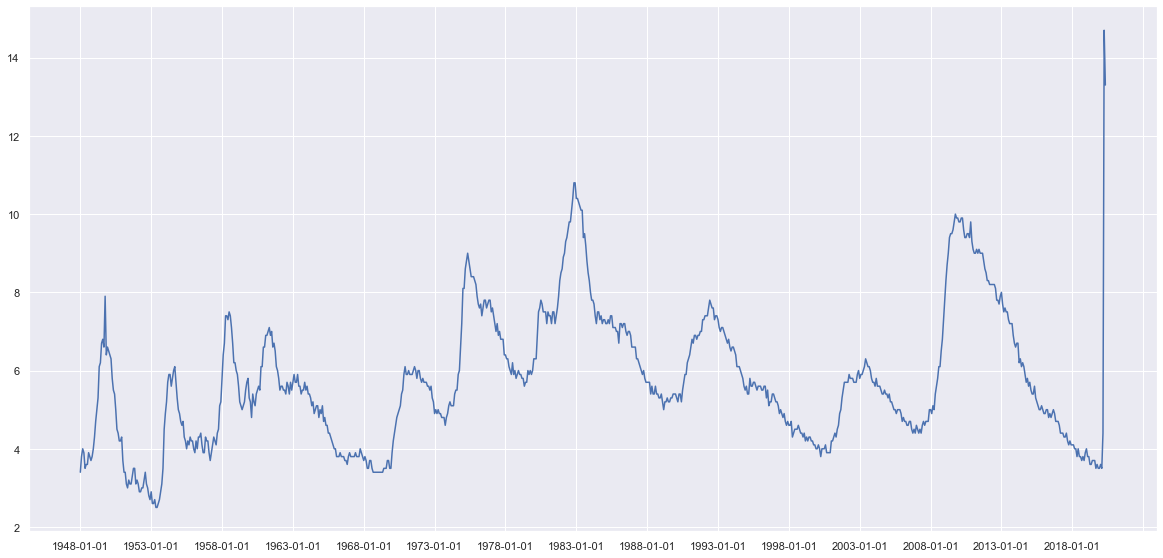

In [105]:
fig, ax = plt.subplots()
ax.plot(unrate['DATE'], unrate['UNRATE'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(60))
plt.show()

### ISM Purchasing Managers Index / Non-manufacturing Index

Another important indicator of the economy, also announced monthly right after the end of each month.

In [109]:
# Load ISM PMI
filename = '../data/MarketData/ISM/ISM-MAN_PMI.csv'

ism_pmi = pd.read_csv(filename, header=0)
ism_pmi = ism_pmi.sort_values(by=['Date'], ascending=True)
ism_pmi

,Date,PMI
868,1948-01-01,51.7
867,1948-02-01,50.2
866,1948-03-01,43.3
865,1948-04-01,45.4
864,1948-05-01,49.5
863,1948-06-01,53.0
862,1948-07-01,48.4
861,1948-08-01,45.1
860,1948-09-01,42.1
859,1948-10-01,47.2


In [108]:
# Load ISM NMI
filename = '../data/MarketData/ISM/ISM-NONMAN_NMI.csv'

ism_nmi = pd.read_csv(filename, header=0)
ism_nmi = ism_nmi.sort_values(by=['Date'], ascending=True)
ism_nmi

,Date,Index
148,2008-01-01,45.0
147,2008-02-01,49.9
146,2008-03-01,49.4
145,2008-04-01,51.8
144,2008-05-01,51.4
143,2008-06-01,48.3
142,2008-07-01,50.0
141,2008-08-01,50.6
140,2008-09-01,49.4
139,2008-10-01,44.7


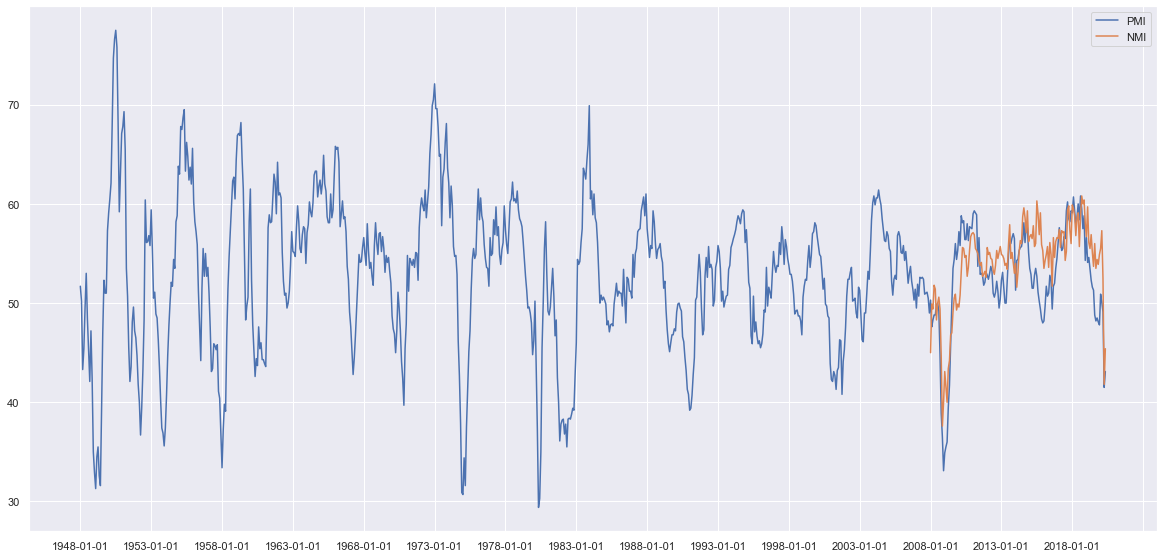

In [112]:
fig, ax = plt.subplots()
ax.plot(ism_pmi['Date'], ism_pmi['PMI'].values)
ax.plot(ism_nmi['Date'], ism_nmi['Index'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(60))
ax.legend(['PMI', 'NMI'])
plt.show()


### Treasury Yield

In [155]:
# Load US Treasury Yield
# https://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=yieldAll
xml_path = '../data/MarketData/Treasury/DailyTreasuryYieldCurveRateData.xml'
xml_data = etree.parse(xml_path) #create an ElementTree object

namespaces = {"base": "http://data.treasury.gov/Feed.svc/",
              "d": "http://schemas.microsoft.com/ado/2007/08/dataservices",
              "m": "http://schemas.microsoft.com/ado/2007/08/dataservices/metadata",
              "x": "http://www.w3.org/2005/Atom"}

df_cols = ["date", "1month", "2month", "3montn", "6montn", "1year", "2year", "3year", "5year", "7year", "10year", "20year", "30year"]
rows = []

contents = xml_data.xpath('/x:feed/x:entry/x:content', namespaces=namespaces)
for content in contents:
    s_date = content.xpath('./m:properties/d:NEW_DATE', namespaces=namespaces)[0].text[:10]
    s_1month = content.xpath('./m:properties/d:BC_1MONTH', namespaces=namespaces)[0].text
    s_2month = content.xpath('./m:properties/d:BC_2MONTH', namespaces=namespaces)[0].text
    s_3month = content.xpath('./m:properties/d:BC_3MONTH', namespaces=namespaces)[0].text
    s_6month = content.xpath('./m:properties/d:BC_6MONTH', namespaces=namespaces)[0].text
    s_1year = content.xpath('./m:properties/d:BC_1YEAR', namespaces=namespaces)[0].text
    s_2year = content.xpath('./m:properties/d:BC_2YEAR', namespaces=namespaces)[0].text
    s_3year = content.xpath('./m:properties/d:BC_3YEAR', namespaces=namespaces)[0].text
    s_5year = content.xpath('./m:properties/d:BC_5YEAR', namespaces=namespaces)[0].text
    s_7year = content.xpath('./m:properties/d:BC_7YEAR', namespaces=namespaces)[0].text
    s_10year = content.xpath('./m:properties/d:BC_10YEAR', namespaces=namespaces)[0].text
    s_20year = content.xpath('./m:properties/d:BC_20YEAR', namespaces=namespaces)[0].text
    s_30year = content.xpath('./m:properties/d:BC_30YEAR', namespaces=namespaces)[0].text
    
    rows.append({"date": dt.datetime.strptime(s_date, '%Y-%m-%d'),
                 "1month": s_1month,
                 "2month": s_2month, 
                 "3montn": s_3month, 
                 "6montn": s_6month, 
                 "1year": s_1year, 
                 "2year": s_2year, 
                 "3year": s_3year, 
                 "5year": s_5year, 
                 "7year": s_7year, 
                 "10year": s_10year, 
                 "20year": s_20year, 
                 "30year": s_30year})

treasury = pd.DataFrame(rows, columns = df_cols).set_index('date').sort_index(ascending=True).astype(float)
treasury

,1month,2month,3montn,6montn,1year,2year,3year,5year,7year,10year,20year,30year
date,,,,,,,,,,,,
1990-01-02,NaN,NaN,7.83,7.89,7.81,7.87,7.90,7.87,7.98,7.94,NaN,8.00
1990-01-03,NaN,NaN,7.89,7.94,7.85,7.94,7.96,7.92,8.04,7.99,NaN,8.04
1990-01-04,NaN,NaN,7.84,7.90,7.82,7.92,7.93,7.91,8.02,7.98,NaN,8.04
1990-01-05,NaN,NaN,7.79,7.85,7.79,7.90,7.94,7.92,8.03,7.99,NaN,8.06
1990-01-08,NaN,NaN,7.79,7.88,7.81,7.90,7.95,7.92,8.05,8.02,NaN,8.09
1990-01-09,NaN,NaN,7.80,7.82,7.78,7.91,7.94,7.92,8.05,8.02,NaN,8.10
1990-01-10,NaN,NaN,7.75,7.78,7.77,7.91,7.95,7.92,8.00,8.03,NaN,8.11
1990-01-11,NaN,NaN,7.80,7.80,7.77,7.91,7.95,7.94,8.01,8.04,NaN,8.11
1990-01-12,NaN,NaN,7.74,7.81,7.76,7.93,7.98,7.99,8.07,8.10,NaN,8.17


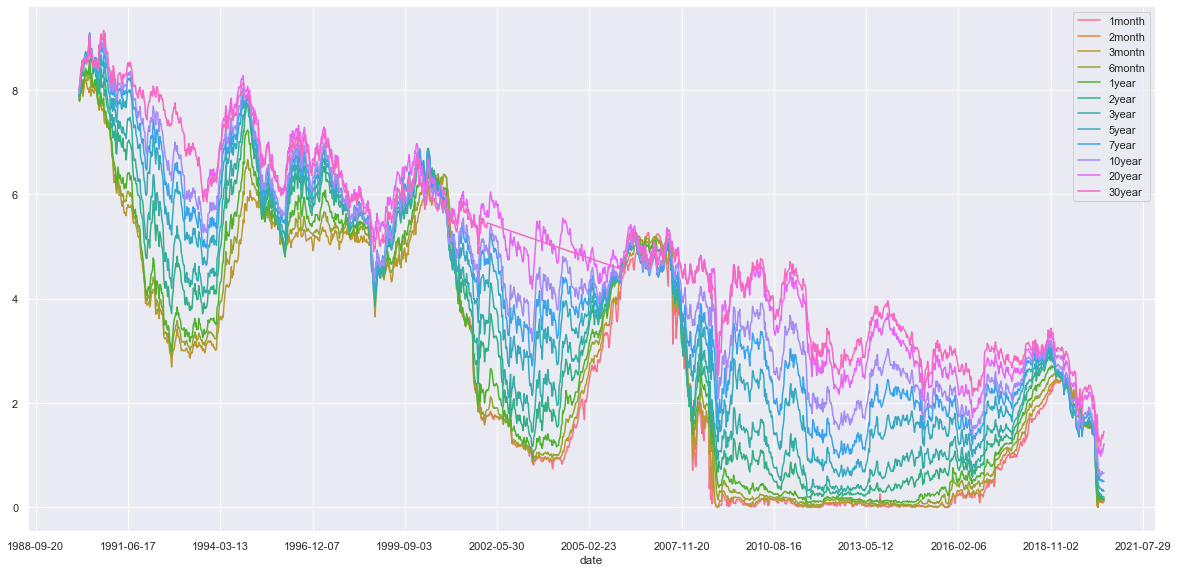

In [160]:
# Use every 5th row as it has too many data points
treasury_5 = treasury.iloc[::5, :]

fig, ax = plt.subplots()
ax = sns.lineplot(data = treasury_5, dashes=False)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1000))
plt.show()

## FOMC Meeting Calendar

### Load Calendar

In [295]:
file = open('../data/FOMC/fomc_calendar.pickle', 'rb')

fomc_calendar = pickle.load(file)
file.close()

print(fomc_calendar.shape)
fomc_calendar

(922, 4)


,date,unscheduled,forecast,confcall
0,1936-03-18,False,False,False
1,1936-03-19,False,False,False
2,1936-05-25,False,False,False
3,1936-11-19,False,False,False
4,1936-11-20,False,False,False
5,1937-01-26,False,False,False
6,1937-03-15,False,False,False
7,1937-04-04,False,False,False
8,1937-05-05,False,False,False
9,1937-06-09,False,False,False


In [296]:
# Take data between 1982/09/27 and 2020/6/5 because we have the target rate in this range.
fomc_calendar = fomc_calendar.loc[fomc_calendar['date'] >= dt.datetime(1982, 9, 27)].loc[fomc_calendar['date'] <= dt.datetime(2020, 6, 5)]
# Use date as index
fomc_calendar.set_index('date', inplace=True)
fomc_calendar.head()

,unscheduled,forecast,confcall
date,,,
1982-10-05,False,False,False
1982-11-16,False,False,False
1982-12-21,False,False,False
1983-01-14,False,False,True
1983-01-21,False,False,True


### Calculate Rate Decisions

In [297]:
# The target range was changed a couple of days after the announcement in the past,
#  while it is immediately put in effect on the day recently.
# Use the target rate three days after the meeting as target announced,
#  compare it with previous day's rate to check if rate has been changed.
#   -1: Rate lower
#    0: No change
#   +1: Rate hike

fomc_calendar['RateDecision'] = None
fomc_calendar['Rate'] = None

for i in range(len(fomc_calendar)):
    for j in range(len(fedrate_df)):
        if fomc_calendar.index[i] == fedrate_df.index[j]:
            fomc_calendar['Rate'].iloc[i] = float(fedrate_df['Rate'].iloc[j+3])
            if fedrate_df['Rate'].iloc[j-1] == fedrate_df['Rate'].iloc[j+3]:
                fomc_calendar['RateDecision'].iloc[i] = 0
            elif fedrate_df['Rate'].iloc[j-1] < fedrate_df['Rate'].iloc[j+3]:
                fomc_calendar['RateDecision'].iloc[i] = 1
            elif fedrate_df['Rate'].iloc[j-1] > fedrate_df['Rate'].iloc[j+3]:
                fomc_calendar['RateDecision'].iloc[i] = -1

fomc_calendar

,unscheduled,forecast,confcall,RateDecision,Rate
date,,,,,
1982-10-05,False,False,False,-1,9.5
1982-11-16,False,False,False,-1,9
1982-12-21,False,False,False,0,8.5
1983-01-14,False,False,True,0,8.5
1983-01-21,False,False,True,0,8.5
1983-01-28,False,False,True,0,8.5
1983-02-09,False,False,False,0,8.5
1983-03-29,False,False,False,1,8.625
1983-04-29,False,False,True,0,8.625


In [298]:
#fedrate_df.head(80)

In [299]:
# # Calculate the next business day (not used for now)
# from pandas.tseries.holiday import USFederalHolidayCalendar
# cal = USFederalHolidayCalendar()
# holidays = cal.holidays(start='1982-01-01', end='2020-12-31').strftime('%Y-%m-%d')
# bdd = np.busdaycalendar(weekmask='1111100', holidays=holidays)

# np.busday_offset('2011-01-01', np.arange(366), roll='forward', busdaycal=bdd)
# np.busday_offset('1982-10-06', 0, roll='forward', busdaycal=bdd)

Though this is not perfect as Target Rate was sometimes changed between FOMC meetings, enough to analyze the impact of FOMC Meetings.

### Add Quantitative Easing as a Lower event
Between 2008 and 2016 saw zero interest rate. Main monetary measure shifted to quantity from rate. Thus, add "lower" events when those QE was announced.

In [272]:
statement_df.head()

,date,contents,speaker,title
0,1994-02-04,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to ...,Alan Greenspan,FOMC Statement
1,1994-03-22,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to...,Alan Greenspan,FOMC Statement
2,1994-04-18,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with ...,Alan Greenspan,FOMC Statement
3,1994-05-17,\n\n[SECTION]\n\nThe Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.\n\n[SECTION]\n\nThe Board approved a...,Alan Greenspan,FOMC Statement
4,1994-08-16,\n\n[SECTION]\n\nThe Federal Reserve announced today the following monetary policy actions:\n\n[SECTION]\n\nThese measures were taken against the background of evidence of continuing strength in t...,Alan Greenspan,FOMC Statement


In [273]:
# Add When QE was first announced on 2008-11-25. No statemenet on that day.
qe_text = "The Federal Reserve announced on Tuesday that it will initiate a program "\
          "to purchase the direct obligations of housing-related government-sponsored "\
          "enterprises (GSEs)--Fannie Mae, Freddie Mac, and the Federal Home Loan Banks "\
          "--and mortgage-backed securities (MBS) backed by Fannie Mae, Freddie Mac, "\
          "and Ginnie Mae.  Spreads of rates on GSE debt and on GSE-guaranteed mortgages "\
          "have widened appreciably of late.  This action is being taken to reduce the cost "\
          "and increase the availability of credit for the purchase of houses, which in turn "\
          "should support housing markets and foster improved conditions in financial markets "\
          "more generally. Purchases of up to $100 billion in GSE direct obligations under "\
          "the program will be conducted with the Federal Reserve's primary dealers through "\
          "a series of competitive auctions and will begin next week.  Purchases of up to "\
          "$500 billion in MBS will be conducted by asset managers selected via a competitive "\
          "process with a goal of beginning these purchases before year-end.  "\
          "Purchases of both direct obligations and MBS are expected to take place over "\
          "several quarters.  Further information regarding the operational details of this "\
          "program will be provided after consultation with market participants."
statement_df = statement_df.append(
    pd.Series([dt.datetime.strptime('2008-11-25', '%Y-%m-%d'), qe_text, 'Ben Bernanke', 'FOMC statement'], index=statements.columns),
    ignore_index=True
)
statement_df.tail()

,date,contents,speaker,title
193,2020-03-23,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Jerome Powell,FOMC Statement
194,2020-03-31,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Jerome Powell,FOMC Statement
195,2020-04-29,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Jerome Powell,FOMC Statement
196,2008-11-25,"The Federal Reserve announced on Tuesday that it will initiate a program to purchase the direct obligations of housing-related government-sponsored enterprises (GSEs)--Fannie Mae, Freddie Mac, and...",Ben Bernanke,FOMC statement
197,2008-11-25,"The Federal Reserve announced on Tuesday that it will initiate a program to purchase the direct obligations of housing-related government-sponsored enterprises (GSEs)--Fannie Mae, Freddie Mac, and...",Ben Bernanke,FOMC statement


In [300]:
# Mark RateDecision = 0 (lower) even when rate is not changed but additional quantitative measures were announced

fomc_calendar = fomc_calendar.append(
    pd.Series([True, False, False, -1, 0.25], index=['unscheduled', 'forecast', 'confcall', 'RateDecision', 'Rate'], name=dt.datetime.strptime('2008-11-25', '%Y-%m-%d'))
) # QE1 Announced
fomc_calendar.loc[fomc_calendar.index == dt.datetime(2009,3,18), 'RateDecision'] = -1 # QE1 Expanded
fomc_calendar.loc[fomc_calendar.index == dt.datetime(2010,11,3), 'RateDecision'] = -1 # QE2 Announced
fomc_calendar.loc[fomc_calendar.index == dt.datetime(2011,9,21), 'RateDecision'] = -1 # Operation Twist Announced
fomc_calendar.loc[fomc_calendar.index == dt.datetime(2012,6,20), 'RateDecision'] = -1 # Operation Twist Extended
fomc_calendar.loc[fomc_calendar.index == dt.datetime(2012,9,13), 'RateDecision'] = -1 # QE3 Announced
fomc_calendar.loc[fomc_calendar.index == dt.datetime(2012,12,12), 'RateDecision'] = -1 # QE3 Expanded

# It was announced QE ends
fomc_calendar.loc[fomc_calendar.index == dt.datetime(2013,6,19), 'RateDecision'] = 1 # Tapering Announced
#fomc_calendar.loc['2013-12-18', 'RateDecision'] = 1 # Tapering Begins
#fomc_calendar.loc['2014-10-29', 'RateDecision'] = 1 # QE3 Terminated
#fomc_calendar.loc['2017-06-14', 'RateDecision'] = 1 # Signaled Balance Sheet Normalization
#fomc_calendar.loc['2017-09-20', 'RateDecision'] = 1 # Stated Balance Sheet Normalization Begins in Oct
fomc_calendar.sort_index(ascending=True, inplace=True)
fomc_calendar

,unscheduled,forecast,confcall,RateDecision,Rate
date,,,,,
1982-10-05,False,False,False,-1,9.5
1982-11-16,False,False,False,-1,9
1982-12-21,False,False,False,0,8.5
1983-01-14,False,False,True,0,8.5
1983-01-21,False,False,True,0,8.5
1983-01-28,False,False,True,0,8.5
1983-02-09,False,False,False,0,8.5
1983-03-29,False,False,False,1,8.625
1983-04-29,False,False,True,0,8.625


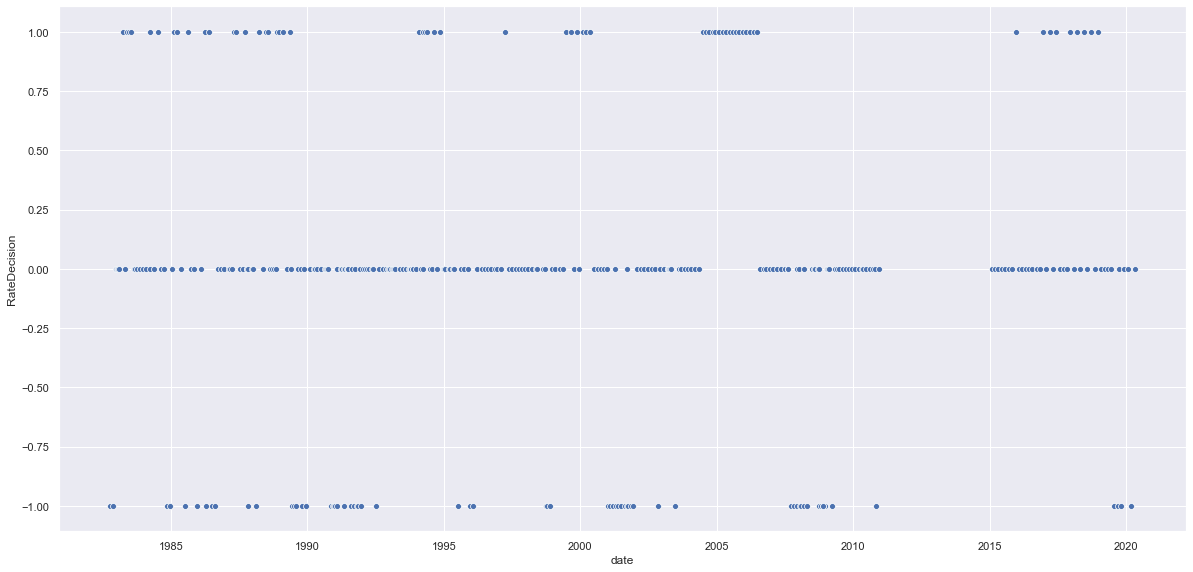

In [293]:
sns.scatterplot(x=fomc_calendar.index, y=fomc_calendar["RateDecision"].apply(lambda x: float(x)))

# Format texts

## Statements DataFrame

In [224]:
statement_df.head()

,date,contents,speaker,title
0,1994-02-04,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to ...,Alan Greenspan,FOMC Statement
1,1994-03-22,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to...,Alan Greenspan,FOMC Statement
2,1994-04-18,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with ...,Alan Greenspan,FOMC Statement
3,1994-05-17,\n\n[SECTION]\n\nThe Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.\n\n[SECTION]\n\nThe Board approved a...,Alan Greenspan,FOMC Statement
4,1994-08-16,\n\n[SECTION]\n\nThe Federal Reserve announced today the following monetary policy actions:\n\n[SECTION]\n\nThese measures were taken against the background of evidence of continuing strength in t...,Alan Greenspan,FOMC Statement


In [326]:
# Reorganize the dataframe
dict = {
    'type': "statement",
    'date': statement_df['date'],
    'title': statement_df['title'],
    'speaker': statement_df['speaker'],
    'word_count': statement_df['contents'].map(get_word_count),
    'decision': statement_df['date'].map(get_rate_change),
    'rate': statement_df['date'].map(get_rate),
    'text': statement_df['contents'].map(lambda x: x.replace('\n','').replace('\r','')),
    'text_sections': statement_df['contents'].map(lambda x: x.replace('\n','').replace('\r','').strip().split("[SECTION]")),
    'org_text': statement_df['contents']
}

proc_statement_df = pd.DataFrame(dict)
print("No rate decision found: ", proc_statement_df['decision'].isnull().sum())
print("Shape of the dataframe: ", proc_statement_df.shape)
#proc_statement_df.dropna(subset=['decision'], axis=0, inplace=True)
proc_statement_df.head(10)

No rate decision found:  0
Shape of the dataframe:  (198, 10)


,type,date,title,speaker,word_count,decision,rate,text,text_sections,org_text
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,1,3.25,[SECTION]Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be assoc...,"[, Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be associated ...",\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to ...
1,statement,1994-03-22,FOMC Statement,Alan Greenspan,40,1,3.50,[SECTION]Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to be asso...,"[, Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to be associated...",\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to...
2,statement,1994-04-18,FOMC Statement,Alan Greenspan,37,1,3.75,[SECTION]Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small ...,"[, Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small increa...",\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with ...
3,statement,1994-05-17,FOMC Statement,Alan Greenspan,160,1,4.25,[SECTION]The Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.[SECTION]The Board approved an increase in th...,"[, The Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion., The Board approved an increase in the discount ra...",\n\n[SECTION]\n\nThe Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.\n\n[SECTION]\n\nThe Board approved a...
4,statement,1994-08-16,FOMC Statement,Alan Greenspan,137,1,4.75,[SECTION]The Federal Reserve announced today the following monetary policy actions:[SECTION]These measures were taken against the background of evidence of continuing strength in the economic expa...,"[, The Federal Reserve announced today the following monetary policy actions:, These measures were taken against the background of evidence of continuing strength in the economic expansion and hig...",\n\n[SECTION]\n\nThe Federal Reserve announced today the following monetary policy actions:\n\n[SECTION]\n\nThese measures were taken against the background of evidence of continuing strength in t...
5,statement,1994-11-15,FOMC Statement,Alan Greenspan,139,1,5.50,"[SECTION]The Federal Reserve Board today approved an increase in the discount rate from 4 percent to 4 3/4 percent, effective immediately.[SECTION]In a related move, the Federal Open Market Commit...","[, The Federal Reserve Board today approved an increase in the discount rate from 4 percent to 4 3/4 percent, effective immediately., In a related move, the Federal Open Market Committee decided t...","\n\n[SECTION]\n\nThe Federal Reserve Board today approved an increase in the discount rate from 4 percent to 4 3/4 percent, ef

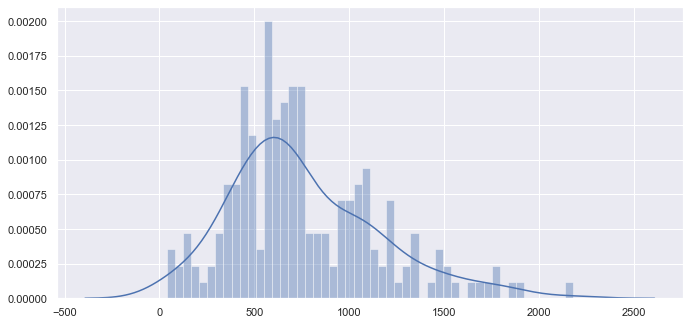

In [327]:
plt.figure(figsize=(10,5))
sns.distplot(proc_statement_df["word_count"].values, bins=50)

In [345]:
proc_statement_df = remove_short_section(proc_statement_df, min_words=50)
proc_statement_df.tail(10)

,type,date,title,speaker,word_count,decision,rate,text,text_sections,org_text
188,statement,2019-10-30,FOMC Statement,Jerome Powell,344,-1,1.75,Information received since the Federal Open Market Committee met in September indicates that the labor market remains strong and that economic activity has been rising at a moderate rate. Job gain...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
189,statement,2019-12-11,FOMC Statement,Jerome Powell,270,0,1.75,Information received since the Federal Open Market Committee met in October indicates that the labor market remains strong and that economic activity has been rising at a moderate rate. Job gains ...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
190,statement,2020-01-29,FOMC Statement,Jerome Powell,271,0,1.75,Information received since the Federal Open Market Committee met in December indicates that the labor market remains strong and that economic activity has been rising at a moderate rate. Job gains...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
191,statement,2020-03-03,FOMC Statement,Jerome Powell,84,-1,1.25,"The fundamentals of the U.S. economy remain strong. However, the coronavirus poses evolving risks to economic activity. In light of these risks and in support of achieving its maximum employment a...","[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
192,statement,2020-03-15,FOMC Statement,Jerome Powell,661,-1,0.25,"The coronavirus outbreak has harmed communities and disrupted economic activity in many countries, including the United States. Global financial conditions have also been significantly affected. A...","[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
193,statement,2020-03-23,FOMC Statement,Jerome Powell,388,0,0.25,The Federal Open Market Committee is taking further actions to support the flow of credit to households and businesses by addressing strains in the markets for Treasury securities and agency mortg...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, 

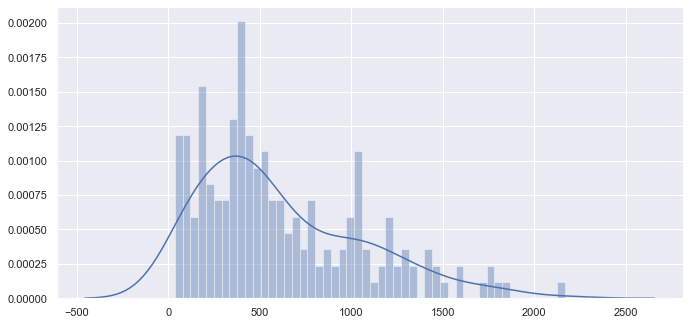

In [332]:
plt.figure(figsize=(10,5))
sns.distplot(proc_statement_df["word_count"].values, bins=50)

### Split contents to max 200 words

In [356]:
split_statement_df = get_split_df(proc_statement_df)
split_statement_df.tail(10)

,type,date,title,speaker,word_count,decision,rate,text,text_sections,org_text
841,statement,2020-03-23,FOMC Statement,Jerome Powell,200,0,0.25,The Federal Open Market Committee is taking further actions to support the flow of credit to households and businesses by addressing strains in the markets for Treasury securities and agency mortg...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
842,statement,2020-03-23,FOMC Statement,Jerome Powell,200,0,0.25,range of to percent The Committee directs the Desk to increase the System Open Market Account holdings of Treasury securities and agency mortgage backed securities MBS in the amounts needed to sup...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
843,statement,2020-03-23,FOMC Statement,Jerome Powell,88,0,0.25,of Treasury securities held outright in the System Open Market Account that are available for such operations and by a per counterparty limit of billion per day The Committee directs the Desk to c...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
844,statement,2020-03-31,FOMC Statement,Jerome Powell,200,0,0.25,The Federal Reserve on Tuesday announced the establishment of a temporary repurchase agreement facility for foreign and international monetary authorities FIMA Repo Facility to help support the sm...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
845,statement,2020-03-31,FOMC Statement,Jerome Powell,99,0,0.25,securities in the open market It should also serve along with the U S dollar liquidity swap lines the Federal Reserve has established with other central banks to help ease strains in global U S do...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
846,statement,2020-04-29,FOMC Statement,Jerome Powell,200,0,0.25,The coronavirus outbreak is causing tremendous human and economic hardship across the United States and around the world The virus and the measures taken to protect public health are inducing shar...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stab

## Minutes DataFrame

In [204]:
sample_text = l_minutes_df.loc['2009-01-28', 'contents']
print(sample_text)

January 27-28, 2009

[SECTION]

PRESENT: Mr. Bernanke, ChairmanMr. Dudley, Vice ChairmanMs. DukeMr. EvansMr. KohnMr. LackerMr. Lockhart Mr. WarshMs. Yellen

[SECTION]

Mr. Bullard, Ms. Cumming, Mr. Hoenig, Ms. Pianalto, and Mr. Rosengren, Alternate Members of the Federal Open Market Committee

[SECTION]

Messrs. Fisher, Plosser, and Stern, Presidents of the Federal Reserve Banks of Dallas, Philadelphia, and Minneapolis, respectively

[SECTION]

Messrs. Altig, Clouse, Connors, Kamin, Slifman, Tracy, and Wilcox, Associate Economists

[SECTION]

Ms. Mosser, Temporary Manager, System Open Market Account

[SECTION]

Ms. Johnson,2 Secretary of the Board, Office of the Secretary, Board of Governors

[SECTION]

Mr. Frierson,2 Deputy Secretary, Office of the Secretary, Board of Governors

[SECTION]

Mr. Struckmeyer, Deputy Staff Director, Office of Staff Director for Management, Board of Governors

[SECTION]

Ms. Bailey, Deputy Director, Division of Banking Supervision and Regulation, Board of 

In [205]:
# Check what kind of sections are in common

a = l_minutes_df.contents.str.lower().str.count('staff economic outlook')
b = l_minutes_df.contents.str.lower().str.count('developments in financial markets')
c = l_minutes_df.contents.str.lower().str.count('staff review of the economic situation')
d = l_minutes_df.contents.str.lower().str.count('staff review of the financial situation')
e = l_minutes_df.contents.str.lower().str.count('participants\' views on current condition')
f = l_minutes_df.contents.str.lower().str.count('committee policy action')
g = l_minutes_df.contents.str.lower().str.count('voting for this action')

pd.DataFrame({'a': a, 'b':b, 'c':c, 'd':d, 'e':e, 'f':f, 'g':g})

#[re.findall("Voting for this action".lower(), text.lower()) for text in  minutes_df['contents']]


,a,b,c,d,e,f,g
date,,,,,,,
1993-02-03,0,0,0,0,0,0,0
1993-03-23,0,0,0,0,0,0,0
1993-05-18,0,0,0,0,0,0,0
1993-07-07,0,0,0,0,0,0,0
1993-08-17,0,0,0,0,0,0,0
1993-09-21,0,0,0,0,0,0,0
1993-11-16,0,0,0,0,0,0,0
1993-12-21,0,0,0,0,0,0,0
1994-02-04,0,1,0,0,0,0,0


Seems we need to extract info but not consistent. Espicially difficut for old minutes. Thus, take another approach to extract paragraphs which are long enough and have some key words.

In [220]:
# Reorganize the dataframe
dict = {
    "type": "minutes",
    "text": l_minutes_df["contents"].values,
    "date": l_minutes_df.index.values,
    "speaker": l_minutes_df["speaker"].values,
    "org_contents": l_minutes_df["contents"].values,
    "target": l_minutes_df.index.map(get_rate_change).values,
    "rate": l_minutes_df.index.map(get_rate).values    
}

minutes_df = pd.DataFrame(dict)
minutes_df.dropna(subset=['target'], axis=0, inplace=True)
minutes_df.reset_index(drop=True, inplace=True)

minutes_df.tail(10)

,type,text,date,speaker,org_contents,target,rate
206,minutes,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",2018-12-19,Jerome Powell,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",2.0,2.50
207,minutes,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",2019-01-30,Jerome Powell,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",1.0,2.50
208,minutes,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",2019-03-20,Jerome Powell,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",1.0,2.50
209,minutes,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",2019-05-01,Jerome Powell,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",1.0,2.50
210,minutes,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",2019-06-19,Jerome Powell,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",1.0,2.50
211,minutes,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",2019-07-31,Jerome Powell,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",0.0,2.25
212,minutes,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",2019-09-18,Jerome Powell,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",0.0,2.00
213,minutes,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",2019-10-30,Jerome Powell,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",0.0,1.75
214,minutes,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",2019-12-11,Jerome Powell,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stab

/Users/yuki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


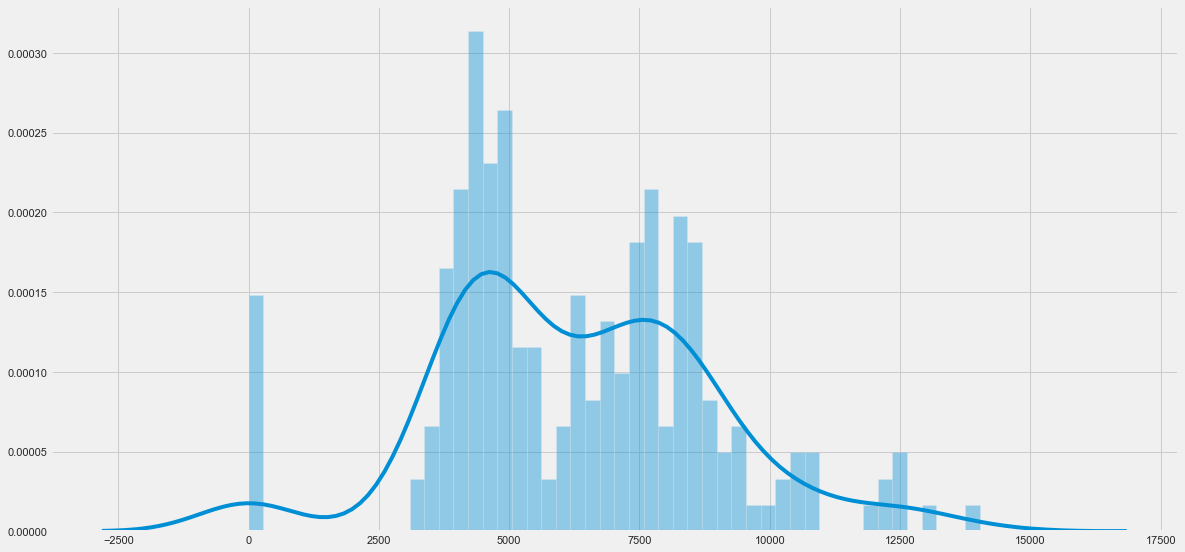

In [223]:
add_word_count(minutes_df)
separate_sections(minutes_df)
sns.distplot(minutes_df["word_count"].values, bins=50)

In [224]:
remove_short_nokeyword(minutes_df)

Before len(df):  216



Kept: 880, Dropped (too short): 12092, Dropped (no keywords): 7656
After len(tmp_minutes_df):  200


/Users/yuki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


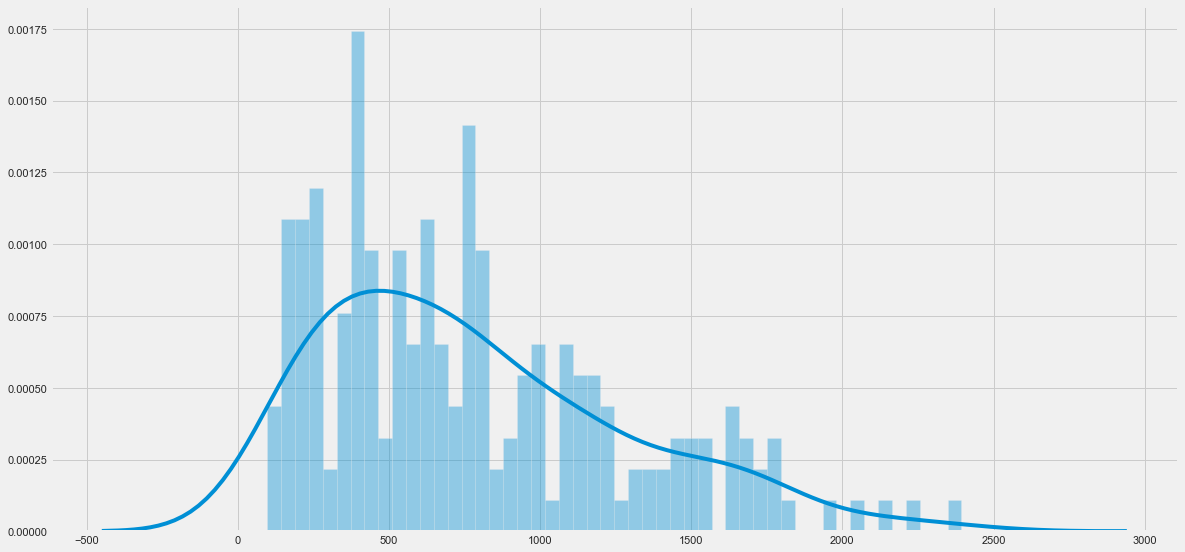

In [225]:
minutes_df.reset_index(drop=True, inplace=True)
add_word_count(minutes_df)
sns.distplot(minutes_df["word_count"].values, bins=50)

In [227]:
minutes_df

,type,text,date,speaker,org_contents,target,rate,word_count,text_sections
0,minutes,"\n\nIn 1993, both M2 and M3 had grown at rates about 1/2 percentage point above the lower bounds of the ranges that the Committee now \r\n contemplated retaining for 1994. According to a staff ...",1994-02-04,Alan Greenspan,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Thursday, February 3, 1994, a...",2.0,3.25,398,"[A meeting of the Federal , pen Market , ommittee was held in \r\n the offices of the Board of Governors of the Federal Reserve , ystem in \r\n Washington, D., ., on , hursday, February 3, 1..."
1,minutes,\n\nMost other market interest rates rose considerably more than \n the federal funds rate in frequently volatile markets. Market \n participants generally had anticipated a tightening of moneta...,1994-03-22,Alan Greenspan,"A meeting of the Federal Open Market Committee was held in \n the offices of the Board of Governors of the Federal Reserve System in \n Washington, D.C., on Tuesday, March 22, 1994, at 9:00 a.m....",2.0,3.50,455,"[A meeting of the Federal , pen Market , ommittee was held in \n the offices of the Board of Governors of the Federal Reserve , ystem in \n Washington, D., ., on , uesday, March 22, 1994, at 9:0..."
2,minutes,\n\nMost other market interest rates rose considerably more than \n the federal funds rate in frequently volatile markets. Market \n participants generally had anticipated a tightening of moneta...,1994-03-22,Alan Greenspan,"A meeting of the Federal Open Market Committee was held in \n the offices of the Board of Governors of the Federal Reserve System in \n Washington, D.C., on Tuesday, March 22, 1994, at 9:00 a.m....",2.0,3.50,455,"[A meeting of the Federal , pen Market , ommittee was held in \n the offices of the Board of Governors of the Federal Reserve , ystem in \n Washington, D., ., on , uesday, March 22, 1994, at 9:0..."
3,minutes,"\n\nMost market interest rates increased by more than the federal \r\n funds rate over the period since the March meeting, with the largest \r\n increases occurring at intermediate maturities. W...",1994-05-17,Alan Greenspan,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, May 17, 1994, at 9:00 a....",2.0,4.25,778,"[A meeting of the Federal , pen Market , ommittee was held in \r\n the offices of the Board of Governors of the Federal Reserve , ystem in \r\n Washington, D., ., on , uesday, May 17, 1994, at 9..."
4,minutes,\n\nThe staff forecast prepared for this meeting suggested that \r\n the economy was operating close to its long-run capacity and that \r\n growth would trend lower over the next several quarter...,1994-08-16,Alan Greenspan,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, August 16, 1994, at 9:00...",2.0,4.75,416,"[A meeting of the Federal , pen Market , ommittee was held in \r\n the offices of the Board of Governors of the Federal Reserve , ystem in \r\n Washington, D., ., on , uesday, August 16, 1994, a..."
5,minutes,"\n\nImmediately after the conclusion of the August meeting, the \r\n Board of Governors approved a 1/2 percentage point increase in the \r\n discount rate to a level of 4 percent. The Committee ...",1994-09-27,Alan Greenspan,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, September 27, 1994, at 9...",2.0,5.50,388,"[A meeting of the Federal , pen Market , ommittee was held in \r\n the offices of the Board of Governors of the Federal Reserve , ystem in \r\n Washington, D., ., on , uesday, , eptember 27, 199..."
6,minutes,"\n\nConsumer confidence remained at 

In [228]:
print(minutes_df['word_count'])

0       398
1       455
2       455
3       778
4       416
5       388
6        97
7       676
8       582
9       974
10      513
11      725
12      735
13      975
14      651
15      436
16      742
17      519
18      169
19      641
20      459
21      308
22      546
23      111
24      606
25      379
26      236
27     1106
28      252
29      362
30      390
31      238
32      143
33      216
34      631
35      209
36      437
37      150
38      813
39      771
40      483
41      641
42      552
43     1538
44      442
45      683
46      804
47      529
48      906
49      234
50      634
51      634
52      155
53      416
54      416
55      416
56      139
57      359
58      355
59      355
60      355
61      245
62      344
63      258
64      147
65      235
66      328
67      484
68      402
69      191
70      187
71      212
72     1106
73      195
74      111
75      231
76      493
77      247
78      273
79      755
80      950
81      229
82      782
83  

### Split contents to max 200 words

In [230]:
minutes_split_df = get_split_df(minutes_df)
print(minutes_split_df.shape)
minutes_split_df.tail()


(940, 6)


,speaker,text,target,rate,date,type
935,Jerome Powell,"Review of Monetary Policy Strategy, Tools, and Communication Practices Participants continued their discussion related to the ongoing review of the Federal Reserve's monetary policy strategy, tool...",1.0,1.75,2020-01-29,minutes
936,Jerome Powell,"of changes in policy rates on asset prices and risk premiums tend to be modest relative to the historical fluctuations in those measures. However, there may be circumstances in which a persistentl...",1.0,1.75,2020-01-29,minutes
937,Jerome Powell,"to the Federal Reserve's administered rates in light of the stability in money market conditions over recent months. With this adjustment, the Board would lift the interest rates on required and e...",1.0,1.75,2020-01-29,minutes
938,Jerome Powell,"low of 3.5 percent in December, and the labor force participation rate and the employment-to-population ratio were unchanged as well. The unemployment rates for African Americans, Asians, Hispanic...",1.0,1.75,2020-01-29,minutes
939,Jerome Powell,"Conditions in domestic short-term funding markets, including in secured financing, were stable over the intermeeting period, even over year-end. Rates declined slightly, likely reflecting increase...",1.0,1.75,2020-01-29,minutes


## Script DataFrame
Press Conference transcripts are available only from 2011

In [233]:
# Sample
print(l_script_df['contents'][2])

CHAIRMAN BERNANKE.  Good afternoon, everybody.  Welcome.  In my opening remarks, I will briefly review today’s policy decision of the Federal Open our policy strategy.  I will then be glad to take your questions.   As indicated in its statement, the Committee decided today to maintain the policies that were initiated at previous meetings.  In particular, the Committee is keeping the target range for the federal funds rate at 0 to ¼ percent and continues to anticipate that economic conditions are likely to warrant exceptionally low levels for the federal funds rate at least through mid-2013. The Committee will continue the program that we announced in September to extend the average maturity of the Federal Reserve’s holdings of securities by purchasing longer-term Treasury securities and selling an equal amount of shorter-term Treasury securities.  Our purchases of longer-term securities exert downward pressures on longer-term interest rates; at the same time, our guidance about the lik

In [234]:
# Reorganize the dataframe
dict = {
    "type": "script",
    "text": l_script_df["contents"].values,
    "date": l_script_df.index.values,
    "speaker": l_script_df["speaker"].values,
    "org_contents": l_script_df["contents"].values,
    "target": l_script_df.index.map(get_rate_change).values,
    "rate": l_script_df.index.map(get_rate).values
}

script_df = pd.DataFrame(dict)
script_df.dropna(subset=['target'], axis=0, inplace=True)
script_df.reset_index(inplace=True)

script_df.head(10)

,index,type,text,date,speaker,org_contents,target,rate
0,0,script,"CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl...",2011-04-27,Ben Bernanke,"CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl...",1,0.25
1,1,script,"CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks today, I’ll briefly review today’s policy decision. And I’ll place the decision in the context of our economic projections ...",2011-06-22,Ben Bernanke,"CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks today, I’ll briefly review today’s policy decision. And I’ll place the decision in the context of our economic projections ...",1,0.25
2,2,script,"CHAIRMAN BERNANKE. Good afternoon, everybody. Welcome. In my opening remarks, I will briefly review today’s policy decision of the Federal Open our policy strategy. I will then be glad to take...",2011-11-02,Ben Bernanke,"CHAIRMAN BERNANKE. Good afternoon, everybody. Welcome. In my opening remarks, I will briefly review today’s policy decision of the Federal Open our policy strategy. I will then be glad to take...",1,0.25
3,3,script,CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks I will briefly review today’s policy decision by the Federal Open to you regarding the Committee’s longer-run policy goals a...,2012-01-25,Ben Bernanke,CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks I will briefly review today’s policy decision by the Federal Open to you regarding the Committee’s longer-run policy goals a...,1,0.25
4,4,script,"CHAIRMAN BERNANKE. Good afternoon. Before we get to questions, I’ll summarize today’s policy action by the Federal Open Market Committee and then I’ll place the Committee’s policy decision in th...",2012-04-25,Ben Bernanke,"CHAIRMAN BERNANKE. Good afternoon. Before we get to questions, I’ll summarize today’s policy action by the Federal Open Market Committee and then I’ll place the Committee’s policy decision in th...",1,0.25
5,5,script,"CHAIRMAN BERNANKE. Good afternoon. Before we get to questions, I’ll summarize today’s policy action by the Federal Open Market Committee and then place the Committee’s appropriate path of moneta...",2012-06-20,Ben Bernanke,"CHAIRMAN BERNANKE. Good afternoon. Before we get to questions, I’ll summarize today’s policy action by the Federal Open Market Committee and then place the Committee’s appropriate path of moneta...",0,0.25
6,6,script,CHAIRMAN BERNANKE. Good afternoon. Earlier today the Federal Open Market Committee (FOMC) approved new measures to support the recovery and employment growth. I’ll get to the specifics of our a...,2012-09-13,Ben Bernanke,CHAIRMAN BERNANKE. Good afternoon. Earlier today the Federal Open Market Committee (FOMC) approved new measures to support the recovery and employment growth. I’ll get to the specifics of our a...,0,0.25
7,7,script,"CHAIRMAN BERNANKE. Good afternoon. It’s been about three and a half years since the economic recovery began. The economy continues to expand at a moderate pace. Unfortunately, however, unemploy...",2012-12-12,Ben Bernanke,"CHAIRMAN BERNANKE. Good afternoon. It’s been about three and a half years since the economic recovery began. The economy continues to expand at a moderate pace. Unfortunately, however, unemploy...",0,0.25
8,8,script,"CHAIRMAN BERNANKE. Good afternoon. The Federal Open Market Committee concluded a two-day meeting earlier today. As always, my colleagues and I reviewed recent economic and financial developmen...",2013-03-20,Ben Bernanke,"CHAIRMAN BERNANKE. Good afternoon. The Federal Open Market Committee concluded a two-day meeting earlier today. As always, my colleagues and I reviewed recent economic and financial developmen...",1,0.

### Split by speakers
Scripts contain words from different people, so split by the speaker

In [242]:
script_data_list = []

for i, row in tqdm(script_df.iterrows(), desc='df.iterrows()'):
    text_list = row["text"].split("\n\n[SECTION]\n\n")
    for text in text_list:
        match = re.findall(r'(^[A-Za-zŞ. ]*[A-Z]{3}).\d? (.*)', text)
        if len(match) == 0:
            match = re.findall(r'(^[A-Za-zŞ. ]*[A-Z]{3}).\d(.*)', text)
            if len(match) == 0:
                print("not matched: ", text)
                print(row['date'])
                print()
        if len(match) == 1:
            speaker, content = match[0]
            script_data_list.append([row.type, content, row.date, speaker, text, row.target, row.rate, ""])        
            
script_speaker_df = pd.DataFrame(script_data_list, columns=['type', 'text', 'date', 'speaker', 'org_contents', 'target', 'rate', 'text_sections'])

In [243]:
add_word_count(script_speaker_df)
separate_sections(script_speaker_df)
script_speaker_df.head()

,type,text,date,speaker,org_contents,target,rate,text_sections,word_count
0,script,"Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterly economic projecti...",2011-04-27,CHAIRMAN BERNANKE,"CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl...",1,0.25,"[ Good afternoon. Welcome. , n my opening remarks, , ’d like to briefly first review today’s policy decision. , ’ll then turn next to the Federal , pen Market , ommittee’s quarterly economic pr...",1582
1,script,"Mr. Chairman, tomorrow we’re going to get a pretty weak first-quarter GDP number. Your own projections for the year have been downgraded in this meeting. How—first of all, what do you see as th...",2011-04-27,QUESTION,"QUESTION. Mr. Chairman, tomorrow we’re going to get a pretty weak first-quarter GDP number. Your own projections for the year have been downgraded in this meeting. How—first of all, what do you...",1,0.25,"[ Mr. , hairman, tomorrow we’re going to get a pretty weak first-quarter GDP number. Your own projections for the year have been downgraded in this meeting. How—first of all, what do you see as ...",64
2,script,"You’re correct. We haven’t seen the GDP number yet. But we, like most private-sector forecasters, are expecting a relatively weak number for the first quarter, maybe something a little under 2 ...",2011-04-27,CHAIRMAN BERNANKE,"CHAIRMAN BERNANKE. You’re correct. We haven’t seen the GDP number yet. But we, like most private-sector forecasters, are expecting a relatively weak number for the first quarter, maybe somethin...",1,0.25,"[ You’re correct. We haven’t seen the GDP number yet. But we, like most private-sector forecasters, are expecting a relatively weak number for the first quarter, maybe something a little under 2...",191
3,script,"Mr. Chairman, given what you know about the pace of the economy now, what is your best guess for how soon the Fed needs to begin to withdraw its extraordinary stimulus for the economy? And could...",2011-04-27,QUESTION,"QUESTION. Mr. Chairman, given what you know about the pace of the economy now, what is your best guess for how soon the Fed needs to begin to withdraw its extraordinary stimulus for the economy? ...",1,0.25,"[ Mr. , hairman, given what you know about the pace of the economy now, what is your best guess for how soon the Fed needs to begin to withdraw its extraordinary stimulus for the economy? And cou...",56
4,script,"Well, currently as the statement suggests, we are in a moderate recovery. We’ll be looking very carefully, first, to see if that recovery is, indeed, sustainable, as we believe it is. And we’ll...",2011-04-27,CHAIRMAN BERNANKE,"CHAIRMAN BERNANKE. Well, currently as the statement suggests, we are in a moderate recovery. We’ll be looking very carefully, first, to see if that recovery is, indeed, sustainable, as we believ...",1,0.25,"[ Well, currently as the statement suggests, we are in a moderate recovery. We’ll be looking very carefully, first, to see if that recovery is, indeed, sustainable, as we believe it is. And we’l...",315


(1971, 9)


/Users/yuki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


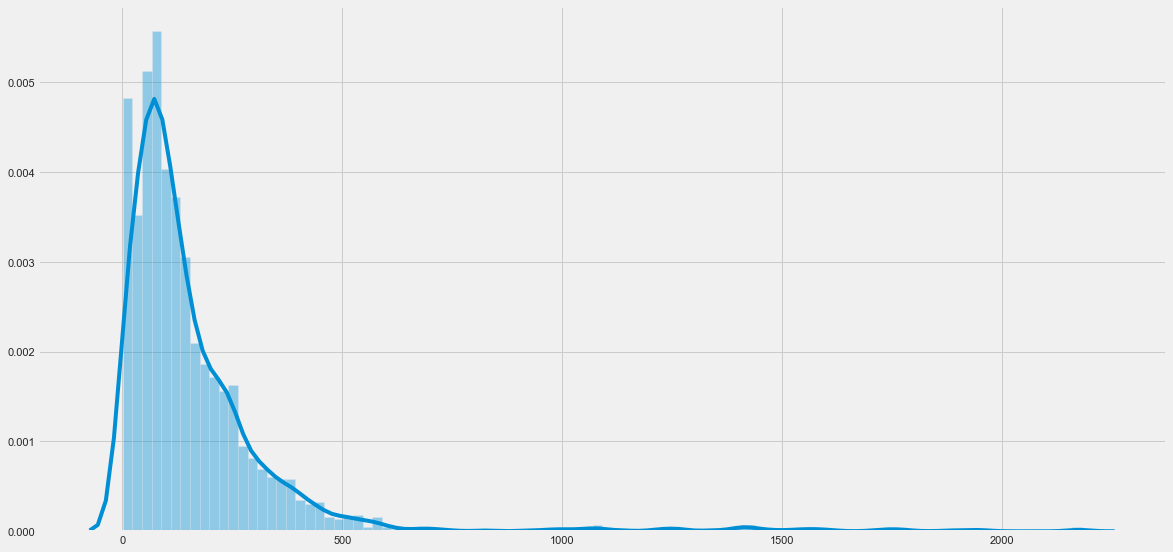

In [244]:
print(script_speaker_df.shape)
sns.distplot(script_speaker_df["word_count"].values, bins=100)

Before len(df):  1971



Kept: 206, Dropped (too short): 406, Dropped (no keywords): 1359
After len(df):  206


/Users/yuki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


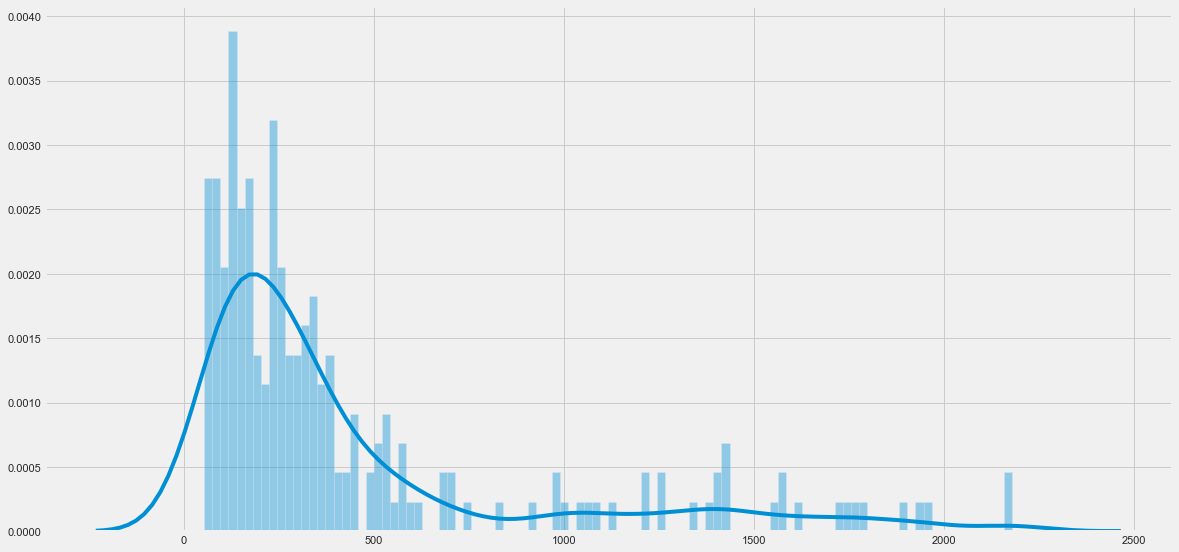

In [245]:
remove_short_nokeyword(script_speaker_df)
sns.distplot(list(script_speaker_df["word_count"]), bins=100)

In [246]:
script_speaker_df.shape

(206, 9)

In [260]:
# script_speaker_df[script_speaker_df['speaker'].str.contains("GREENSPAN|YELLEN|BERNANKE|POWELL")]

# Scripts are from 2011, so Greenspan's scripts are not avialable.
# script_greenspan = script_speaker_df[script_speaker_df['speaker'].str.contains("GREENSPAN")]
# script_greenspan['speaker'] = 'Alan Greenspan'

script_bernanke = script_speaker_df.loc[script_speaker_df['speaker'].str.upper().str.contains("BERNANKE"),:]
script_bernanke.loc[:, 'speaker'] = 'Ben Bernanke'
print(script_bernanke.shape)

script_yellen = script_speaker_df.loc[script_speaker_df['speaker'].str.upper().str.contains("YELLEN"),:]
script_yellen.loc[:, 'speaker'] = 'Janet Yellen'
print(script_yellen.shape)

script_powell = script_speaker_df.loc[script_speaker_df['speaker'].str.upper().str.contains("POWELL"),:]
script_powell.loc[:, 'speaker'] = 'Jerome Powell'
print(script_powell.shape)

script_gbyp_df = pd.concat([script_bernanke, script_yellen, script_powell], ignore_index=True)
script_gbyp_df

/Users/yuki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


(52, 9)
(61, 9)
(46, 9)


,type,text,date,speaker,org_contents,target,rate,text_sections,word_count
0,script,"\n\n Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterly economic proj...",2011-04-27,Ben Bernanke,"CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl...",1,0.25,"[ Good afternoon. Welcome. , n my opening remarks, , ’d like to briefly first review today’s policy decision. , ’ll then turn next to the Federal , pen Market , ommittee’s quarterly economic pr...",1582
1,script,"\n\n Good afternoon and welcome. In my opening remarks today, I’ll briefly review today’s policy decision. And I’ll place the decision in the context of our economic projections and our policy ...",2011-06-22,Ben Bernanke,"CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks today, I’ll briefly review today’s policy decision. And I’ll place the decision in the context of our economic projections ...",1,0.25,"[ Good afternoon and welcome. , n my opening remarks today, , ’ll briefly review today’s policy decision. And , ’ll place the decision in the context of our economic projections and our policy ...",1134
2,script,"\n\n Good afternoon, everybody. Welcome. In my opening remarks, I will briefly review today’s policy decision of the Federal Open our policy strategy. I will then be glad to take your questions...",2011-11-02,Ben Bernanke,"CHAIRMAN BERNANKE. Good afternoon, everybody. Welcome. In my opening remarks, I will briefly review today’s policy decision of the Federal Open our policy strategy. I will then be glad to take...",1,0.25,"[ Good afternoon, everybody. Welcome. , n my opening remarks, , will briefly review today’s policy decision of the Federal , pen our policy strategy. , will then be glad to take your question...",1251
3,script,\n\n Good afternoon and welcome. In my opening remarks I will briefly review today’s policy decision by the Federal Open to you regarding the Committee’s longer-run policy goals and strategy. A...,2012-01-25,Ben Bernanke,CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks I will briefly review today’s policy decision by the Federal Open to you regarding the Committee’s longer-run policy goals a...,1,0.25,"[ Good afternoon and welcome. , n my opening remarks , will briefly review today’s policy decision by the Federal , pen to you regarding the , ommittee’s longer-run policy goals and strategy. ...",1931
4,script,"\n\n Well, let me first observe that we have in fact, of course, been very accommodative in the last couple of years. We’ve kept interest rates close to zero, we’ve done two rounds of asset purch...",2012-01-25,Ben Bernanke,"CHAIRMAN BERNANKE. Well, let me first observe that we have in fact, of course, been very accommodative in the last couple of years. We’ve kept interest rates close to zero, we’ve done two rounds...",1,0.25,"[ Well, let me first observe that we have in fact, of course, been very accommodative in the last couple of years. We’ve kept interest rates close to zero, we’ve done two rounds of asset purchase...",230
5,script,"\n\n Well, you’re referring, I think, to the 165–166 rules, which will focus on the supervisory oversight of the largest banks. It’s a very big and complicated rule, as everyone knows, and so our...",2012-01-25,Ben Bernanke,"CHAIRMAN BERNANKE. Well, you’re referring, I think, to the 165–166 rules, which will focus on the supervisory oversight of the largest banks. It’s a very big and complicated rule, as everyone kn...",1,0.25,"[ Well, you’re referring, , think, to the 165–166 rules, which will focus on the supervisory oversight of the largest banks. , t’s a very big and complicated rule, as everyone knows, and so our ...",437
6,script,"\n\n Well, again, first I want to emphasize that there is no mechan

In [261]:
script_bernanke

,type,text,date,speaker,org_contents,target,rate,text_sections,word_count
0,script,"\n\n Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterly economic proj...",2011-04-27,Ben Bernanke,"CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl...",1,0.25,"[ Good afternoon. Welcome. , n my opening remarks, , ’d like to briefly first review today’s policy decision. , ’ll then turn next to the Federal , pen Market , ommittee’s quarterly economic pr...",1582
43,script,"\n\n Good afternoon and welcome. In my opening remarks today, I’ll briefly review today’s policy decision. And I’ll place the decision in the context of our economic projections and our policy ...",2011-06-22,Ben Bernanke,"CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks today, I’ll briefly review today’s policy decision. And I’ll place the decision in the context of our economic projections ...",1,0.25,"[ Good afternoon and welcome. , n my opening remarks today, , ’ll briefly review today’s policy decision. And , ’ll place the decision in the context of our economic projections and our policy ...",1134
83,script,"\n\n Good afternoon, everybody. Welcome. In my opening remarks, I will briefly review today’s policy decision of the Federal Open our policy strategy. I will then be glad to take your questions...",2011-11-02,Ben Bernanke,"CHAIRMAN BERNANKE. Good afternoon, everybody. Welcome. In my opening remarks, I will briefly review today’s policy decision of the Federal Open our policy strategy. I will then be glad to take...",1,0.25,"[ Good afternoon, everybody. Welcome. , n my opening remarks, , will briefly review today’s policy decision of the Federal , pen our policy strategy. , will then be glad to take your question...",1251
128,script,\n\n Good afternoon and welcome. In my opening remarks I will briefly review today’s policy decision by the Federal Open to you regarding the Committee’s longer-run policy goals and strategy. A...,2012-01-25,Ben Bernanke,CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks I will briefly review today’s policy decision by the Federal Open to you regarding the Committee’s longer-run policy goals a...,1,0.25,"[ Good afternoon and welcome. , n my opening remarks , will briefly review today’s policy decision by the Federal , pen to you regarding the , ommittee’s longer-run policy goals and strategy. ...",1931
132,script,"\n\n Well, let me first observe that we have in fact, of course, been very accommodative in the last couple of years. We’ve kept interest rates close to zero, we’ve done two rounds of asset purch...",2012-01-25,Ben Bernanke,"CHAIRMAN BERNANKE. Well, let me first observe that we have in fact, of course, been very accommodative in the last couple of years. We’ve kept interest rates close to zero, we’ve done two rounds...",1,0.25,"[ Well, let me first observe that we have in fact, of course, been very accommodative in the last couple of years. We’ve kept interest rates close to zero, we’ve done two rounds of asset purchase...",230
142,script,"\n\n Well, you’re referring, I think, to the 165–166 rules, which will focus on the supervisory oversight of the largest banks. It’s a very big and complicated rule, as everyone knows, and so our...",2012-01-25,Ben Bernanke,"CHAIRMAN BERNANKE. Well, you’re referring, I think, to the 165–166 rules, which will focus on the supervisory oversight of the largest banks. It’s a very big and complicated rule, as everyone kn...",1,0.25,"[ Well, you’re referring, , think, to the 165–166 rules, which will focus on the supervisory oversight of the largest banks. , t’s a very big and complicated rule, as everyone knows, and so our ...",437
145,script,"\n\n Well, again, first I want to emphasize that there is

Before:  (159, 9)



After (41, 9)


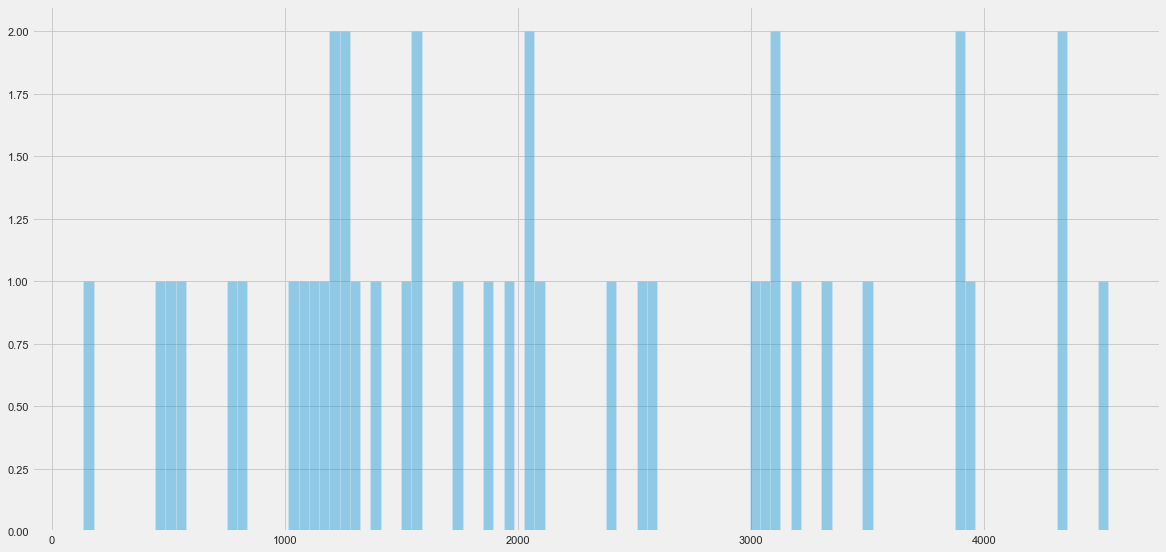

In [262]:
# Combine scripts for the same day.
tmp_date = ''
tmp_speaker = ''
tmp_data = []

print('Before: ', script_gbyp_df.shape)

for i, row in tqdm(script_gbyp_df.iterrows()):
    if row.date == tmp_date and row.speaker == tmp_speaker:
        tmp_data[-1]['text'] += row.text
        tmp_data[-1]['org_contents'] += row.org_contents
        tmp_data[-1]['word_count'] += row.word_count
    else:
        tmp_date = row.date
        tmp_speaker = row.speaker
        tmp_data.append(row)

script_gbyp_combined_df = pd.DataFrame(tmp_data)

print('After', script_gbyp_combined_df.shape)
script_gbyp_combined_df.head()

sns.distplot(list(script_gbyp_combined_df['word_count']), bins=100, kde=False)

### Split contents to max 200 words

In [263]:
script_split_df = get_split_df(script_gbyp_df)
print(script_split_df.shape)
script_split_df.tail()


(504, 6)


,speaker,text,target,rate,date,type
499,Jerome Powell,"sustained basis, the necessary quantity of overnight and term repo will gradually decline. We’ve already begun the gradual reduction in the quantity of repo, and we’ll continue to reduce those off...",1,1.75,2020-01-29,script
500,Jerome Powell,"to remain ample even when the TGA peaks during the April tax season. Effectively, what that means is that we need reserves at all times to be no lower than they were in early September—and, I woul...",1,1.75,2020-01-29,script
501,Jerome Powell,"Don’t know that. We want it to be well within the range. I think we’ll continue to adjust it to the extent it’s appropriate. Ultimately, what we’re trying to do is deliver a federal funds rate tha...",1,1.75,2020-01-29,script
502,Jerome Powell,So I do agree that—the principles that he articulated of firm and fair supervision and effective transparency in communications. I also think it’s a good thing that we would have brighter lines to...,1,1.75,2020-01-29,script
503,Jerome Powell,"So, as I’ve noted on a number of occasions, really, the Committee—as you know, we did a year-plus-long study of our tools and strategies and communications. And we, really, at the end of that, and...",0,0.25,2020-03-15,script


## Speech DataFrame

In [267]:
# Reorganize the dataframe
dict = {
    "type": "speech",
    "text": l_speech_df["contents"].values,
    "date": l_speech_df.index.values,
    "speaker": l_speech_df["speaker"].values,
    "org_contents": l_speech_df["contents"].values,
    "target": l_speech_df.index.map(get_rate_change),
    "rate": l_speech_df.index.map(get_rate)
}

speech_df = pd.DataFrame(dict)
speech_df.reset_index(drop=True, inplace=True)
speech_df.dropna(subset=['target'], axis=0, inplace=True)

speech_df.head(10)

,type,text,date,speaker,org_contents,target,rate
0,speech,"Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\...",1996-06-13,Chairman Alan Greenspan,"Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\...",2,5.5
1,speech,"Remarks by Governor Edward W. Kelley, Jr.\nDevelopments in electronic money and banking\r\nAt the CyberPayments '96 Conference, Dallas, Texas\r\nJune 18, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nIt i...",1996-06-18,"Governor Edward W. Kelley, Jr.","Remarks by Governor Edward W. Kelley, Jr.\nDevelopments in electronic money and banking\r\nAt the CyberPayments '96 Conference, Dallas, Texas\r\nJune 18, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nIt i...",2,5.5
2,speech,Monetary Policy Objectives and Strategy\n\n[SECTION]\n\nI want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I al...,1996-09-08,Governor Laurence H. Meyer,Monetary Policy Objectives and Strategy\n\n[SECTION]\n\nI want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I al...,2,5.5
3,speech,"Remarks by Chairman Alan Greenspan\nRegulation of electronic payment systems\r\nAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC \r\nSeptember 1...",1996-09-19,Chairman Alan Greenspan,"Remarks by Chairman Alan Greenspan\nRegulation of electronic payment systems\r\nAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC \r\nSeptember 1...",2,5.5
4,speech,"Remarks by Governor Lawrence B. Lindsey\r\nAt the Small Business Development Conference, Richmond, Virginia\r\nOctober 2, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nSmall Business Is Big Business\n\n[S...",1996-10-02,Governor Lawrence B. Lindsey,"Remarks by Governor Lawrence B. Lindsey\r\nAt the Small Business Development Conference, Richmond, Virginia\r\nOctober 2, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nSmall Business Is Big Business\n\n[S...",2,5.5
5,speech,"Remarks by Chairman Alan Greenspan\nBank supervision, regulation, and risk\r\nAt the Annual Convention of the American Bankers Association, Honolulu, Hawaii \r\nOctober 5, 1996\n\n[SECTION]\n\n\n\...",1996-10-05,Chairman Alan Greenspan,"Remarks by Chairman Alan Greenspan\nBank supervision, regulation, and risk\r\nAt the Annual Convention of the American Bankers Association, Honolulu, Hawaii \r\nOctober 5, 1996\n\n[SECTION]\n\n\n\...",2,5.5
6,speech,"Remarks by Chairman Alan Greenspan\nU.S. Treasury securities market: Lessons from Alexander Hamilton\r\nAt the Annual Public Service Awards Dinner of the Public Securities Association, New York, N...",1996-10-07,Chairman Alan Greenspan,"Remarks by Chairman Alan Greenspan\nU.S. Treasury securities market: Lessons from Alexander Hamilton\r\nAt the Annual Public Service Awards Dinner of the Public Securities Association, New York, N...",2,5.5
7,speech,"Remarks by Governor Lawrence B. Lindsey\r\nAt the Community Development Lending Conference, Dallas, Texas\r\nOctober 9, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nHere We Go Again?\n\n[SECTION]\n\nThan...",1996-10-09,Governor Lawrence B. Lindsey,"Remarks by Governor Lawrence B. Lindsey\r\nAt the Community Development Lending Conference, Dallas, Texas\r\nOctober 9, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nHere We Go Again?\n\n[SECTION]\n\nThan...",2,5.5
8,speech,"Remarks by Governor Lawrence B. Lindsey\r\nAt the Atlantic Economic Society, Washington, D.C.\r\nOctober 11, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nHow To Grow Faster\n\n[SECTION]\n\nIt is my pleas...",1996-10-11,Governor Lawrence B. Lindsey,"Remarks by Governor Lawrence B. Lindsey\r\nAt the A

/Users/yuki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


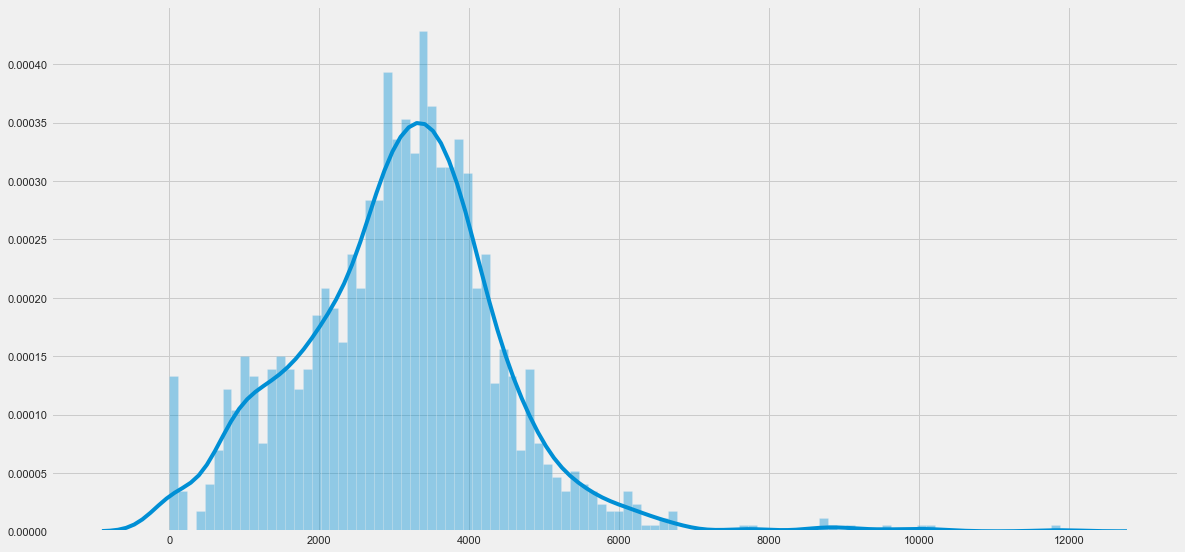

In [269]:
add_word_count(speech_df)
separate_sections(speech_df)
sns.distplot(speech_df["word_count"].values, bins=100)

In [270]:
remove_short_nokeyword(speech_df)

Before len(df):  1455



Kept: 1874, Dropped (too short): 43652, Dropped (no keywords): 33324
After len(df):  643


In [271]:
print(speech_df.shape)
speech_df.head(10)

(643, 9)


,type,text,date,speaker,org_contents,target,rate,word_count,text_sections
2,speech,"\n\nEconomic theory, in the form of the long-run neutrality of money, tells us that monetary policy cannot affect the level or growth rate of output in the long run. So don't saddle monetary poli...",1996-09-08,Governor Laurence H. Meyer,Monetary Policy Objectives and Strategy\n\n[SECTION]\n\nI want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I al...,2,5.50,2934,"[Monetary Policy , bjectives and , trategy\n\n[, , , , , , , ]\n\n, want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment..."
7,speech,\n\nWithout any question the most important economic development has been a decline in the underlying rate of inflation and the consequent decline in medium- and long-term interest rates. Let's d...,1996-10-09,Governor Lawrence B. Lindsey,"Remarks by Governor Lawrence B. Lindsey\r\nAt the Community Development Lending Conference, Dallas, Texas\r\nOctober 9, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nHere We Go Again?\n\n[SECTION]\n\nThan...",2,5.50,3672,"[Remarks by Governor Lawrence B. Lindsey\r\nAt the , ommunity Development Lending , onference, Dallas, , exas\r\n, ctober 9, 1996\n\n[, , , , , , , ]\n\n\n\n[, , , , , , , ]\n\nHere We Go Again?\n..."
8,speech,"\n\nThe analogy in the private sector is the hurdle rate of return. Firms evaluate project\r\nproposals based on their likely yield to the bottom line, accepting only those projects which\r\nmeet...",1996-10-11,Governor Lawrence B. Lindsey,"Remarks by Governor Lawrence B. Lindsey\r\nAt the Atlantic Economic Society, Washington, D.C.\r\nOctober 11, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nHow To Grow Faster\n\n[SECTION]\n\nIt is my pleas...",2,5.50,4819,"[Remarks by Governor Lawrence B. Lindsey\r\nAt the Atlantic , conomic , ociety, Washington, D., .\r\n, ctober 11, 1996\n\n[, , , , , , , ]\n\n\n\n[, , , , , , , ]\n\nHow , o Grow Faster\n\n[, , , ..."
17,speech,"\n\nBut, unless future taxes and/or benefits are sufficiently adjusted, there is no substitute for increased domestic savings and investment currently. To be sure, for relatively short periods of...",1996-12-06,Chairman Alan Greenspan,"\n\n[SECTION]\n\nI am privileged to accept the Union League of Philadelphia's Abraham Lincoln award. This is the first time I have been at the Union League in nearly four decades, but I am gratif...",2,5.50,2662,"[\n\n[, , , , , , , ]\n\n, am privileged to accept the Union League of Philadelphia's Abraham Lincoln award. , his is the first time , have been at the Union League in nearly four decades, but ..."
19,speech,"\n\nFirst, the staff regularly provides alternative forecasts roughly corresponding to the policy options that will be considered at the upcoming FOMC meeting. The staff first imposes the judgmen...",1997-01-05,Governor Laurence H. Meyer,\n\n[SECTION]\n\nThe Role for Structural Macroeconomic Models\n\n[SECTION]\n\nI am in the middle of my third interesting and active encounter with the development and/or use of macroeconometric mo...,2,5.50,3309,"[\n\n[, , , , , , , ]\n\n, he Role for , tructural Macroeconomic Models\n\n[, , , , , , , ]\n\n, am in the middle of my third interesting and active encounter with the development and/or use of m..."
21,speech,\n\nThere are two types of evidence supporting the hypothesis that workers have become less secure about their jobs. The first is that the proportion of workers who have suffered a permanent job ...,1997-01-16,Governor Laurence H. Meyer,\n\n[SECTION]\n\nThe Economic Outlook and Challenges for Monetary Policy\n\n[SECTION]\n\n1996 was an extraordinarily good year for the economy. Measured on a fourth quarter to fourth quarter basi...,2,5.50,4295,"[\n\n[, , , , , , , ]\n\n, he , conomic , utlook and , hallenges for Monetary Policy\n\n[, , , , , , , ]\n\n1996 was an extraordinarily good year for the eco

/Users/yuki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


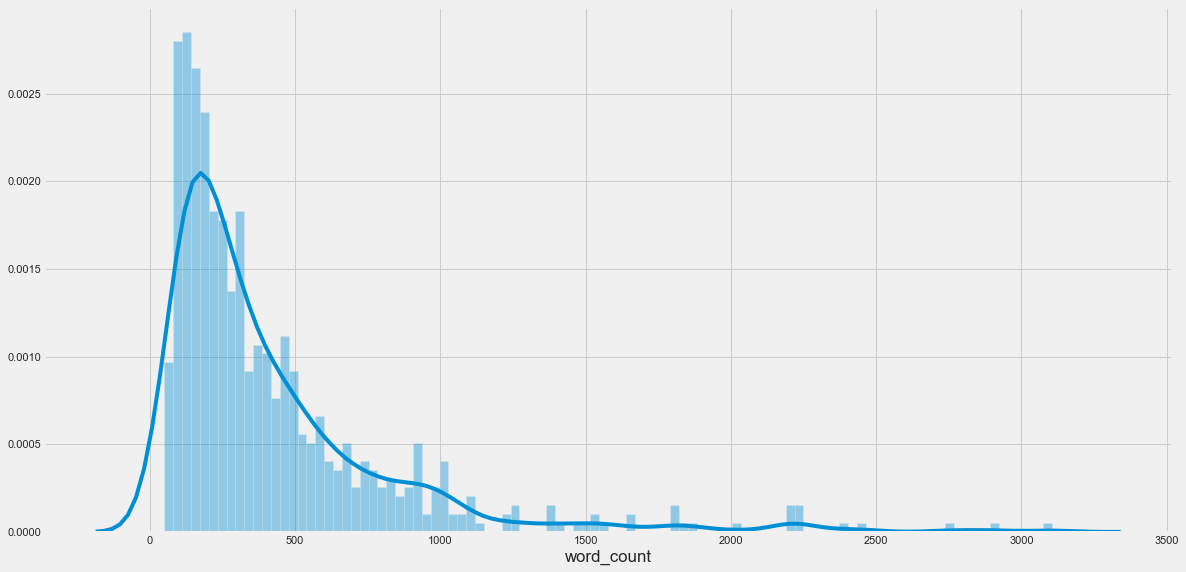

In [272]:
speech_df.reset_index(drop=True, inplace=True)
add_word_count(speech_df)
sns.distplot(speech_df["word_count"], bins=100)

In [273]:
speech_df.loc[tmp_speech_df['word_count'] > 5000]

,type,text,date,speaker,org_contents,target,rate,word_count,text_sections
12,speech,"\n\nWhile Chairman Greenspan and his fellow policymakers identified the credit crunch in a fairly timely fashion, it took some time to appreciate the full force of its power. By my reading, in th...",1997-09-12,Governor Laurence H. Meyer,"\n\n[SECTION]\n\nMonetary Policy and the Bond Market: Complements or Substitutes?\n\n[SECTION]\n\nIt is a pleasure to speak this afternoon at the Fixed Income Summit. To some analysts, a meeting...",0,5.25,731,"[\n\n[, , , , , , , ]\n\nMonetary Policy and the Bond Market: , omplements or , ubstitutes?\n\n[, , , , , , , ]\n\n, t is a pleasure to speak this afternoon at the Fixed , ncome , ummit. , o som..."
13,speech,"\n\nWith respect to inflation, the netting of the crosscurrents suggests a modest increase in inflation in 1998, albeit from a steadily downward-revised and very low rate in 1997. I will pay very...",1997-09-17,Governor Laurence H. Meyer,"\n\n[SECTION]\n\nThe Economic Outlook and Challenges Facing Monetary Policy\n\n[SECTION]\n\nRecent economic performance has been hailed on Wall Street as ""paradise found"" and the ""best of times."" ...",0,5.25,670,"[\n\n[, , , , , , , ]\n\n, he , conomic , utlook and , hallenges Facing Monetary Policy\n\n[, , , , , , , ]\n\nRecent economic performance has been hailed on Wall , treet as ""paradise found"" and t..."
20,speech,"\n\nEpisodes of vicious cycles cannot be easily forecast, as our recent experience with Asia has demonstrated. Certainly, there were indications that Thailand's large current account deficits wer...",1998-02-27,Chairman Alan Greenspan,It is a pleasure to address this conference on risk management once again. The conference has consistently been an interesting and constructive one. I regret that I cannot attend in person.\n\n[...,0,5.25,321,"[, t is a pleasure to address this conference on risk management once again. , he conference has consistently been an interesting and constructive one. , regret that , cannot attend in person...."
34,speech,"\n\nA source of such discontinuity arises from possible devaluations in countries on a fixed or pegged exchange rate. Whereas under floating rates, a gradual depreciation could take some pressure...",1998-10-05,Governor Laurence H. Meyer,"The Economic Outlook and the Challenges Facing Monetary Policy\n\n[SECTION]\n\nIt is always a pleasure to participate at the annual NABE meetings, especially at a session chaired by my former part...",0,5.00,272,"[, he , conomic , utlook and the , hallenges Facing Monetary Policy\n\n[, , , , , , , ]\n\n, t is always a pleasure to participate at the annual , AB, meetings, especially at a session chaired by..."
54,speech,"\n\nOf course, at the Federal Reserve, the key question is, What does higher productivity growth mean for monetary policy? First, monetary policy never should target a specific rate of growth in ...",1999-09-08,Governor Laurence H. Meyer,\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nQ&A on the Economic Outlook and the Challenges Facing Monetary Policy\n\n[SECTION]\n\nOften the most interesting part of a prese...,1,5.25,1259,"[\n\n[, , , , , , , ]\n\n\n\n[, , , , , , , ]\n\n\n\n[, , , , , , , ]\n\n\n\n[, , , , , , , ]\n\nQ&A on the , conomic , utlook and the , hallenges Facing Monetary Policy\n\n[, , , , , , , ]\n\n, f..."
78,speech,\n\nThe Economic Policies of the Last Century\r\nA very broad reading of economic history reveals that policymakers in many countries during the last century attempted to manipulate trade and othe...,2000-05-12,"Vice Chairman Roger W. Ferguson, Jr.","\n\n[SECTION]\n\n\n\n[SECTION]\n\nEconomic Policy for Our Era: The Florida Experience\n\n[SECTION]\n\nToday, I would like to offer some observations, from the perspective of a policymaker, on the ...",2,6.50,160,"[\n\n[, , , , , , , ]\n\n\n\n[, , , , , , , ]\n\n, conomic Policy for , ur , ra: , he Florida , xperience\n\n[, , , , , , , ]\n\n, oday, , woul

In [274]:
#print(tmp_speech_df.iloc[29].text)
for i, row in speech_df.iterrows():
    print(row.date, row.speaker)

1996-09-08 00:00:00 Governor Laurence H. Meyer
1996-10-09 00:00:00 Governor Lawrence B. Lindsey
1996-10-11 00:00:00 Governor Lawrence B. Lindsey
1996-12-06 00:00:00 Chairman Alan Greenspan
1997-01-05 00:00:00 Governor Laurence H. Meyer
1997-01-16 00:00:00 Governor Laurence H. Meyer
1997-01-29 00:00:00 Governor Edward W. Kelley, Jr.
1997-04-04 00:00:00 Vice Chair Alice M. Rivlin
1997-04-24 00:00:00 Governor Laurence H. Meyer
1997-05-08 00:00:00 Chairman Alan Greenspan
1997-09-04 00:00:00 Governor Laurence H. Meyer
1997-09-05 00:00:00 Chairman Alan Greenspan
1997-09-12 00:00:00 Governor Laurence H. Meyer
1997-09-17 00:00:00 Governor Laurence H. Meyer
1997-10-11 00:00:00 Chairman Alan Greenspan
1997-10-14 00:00:00 Governor Laurence H. Meyer
1997-12-02 00:00:00 Chairman Alan Greenspan
1998-01-03 00:00:00 Chairman Alan Greenspan
1998-01-08 00:00:00 Governor Laurence H. Meyer
1998-01-12 00:00:00 Chairman Alan Greenspan
1998-02-27 00:00:00 Chairman Alan Greenspan
1998-02-27 00:00:00 Governor 

In [278]:
print(len(speech_df))
# Check records where speaker is null
speech_df.loc[speech_df['speaker']=='']

642


,type,text,date,speaker,org_contents,target,rate,word_count,text_sections


In [279]:
# Drop records when speaker is null
speech_df.drop(speech_df.loc[speech_df['speaker']==''].index, axis=0, inplace=True)

In [280]:
print(len(speech_df))
speech_df.loc[tmp_speech_df['speaker']=='']

642


,type,text,date,speaker,org_contents,target,rate,word_count,text_sections


In [281]:
remove_return_code(speech_df)

In [288]:
speech_greenspan = speech_df.loc[speech_df['speaker'].str.upper().str.contains("GREENSPAN"),:]
speech_greenspan.loc[:, 'speaker'] = 'Alan Greenspan'

speech_bernanke = speech_df.loc[speech_df['speaker'].str.contains("BERNANKE|Bernanke|bernanke")]
speech_bernanke.loc[:, 'speaker'] = 'Ben Bernanke'

speech_yellen = speech_df.loc[speech_df['speaker'].str.contains("YELLEN|Yellen|yellen")]
speech_yellen.loc[:, 'speaker'] = 'Janet Yellen'

speech_powell = speech_df.loc[speech_df['speaker'].str.contains("POWELL|Powell|powell")]
speech_powell.loc[:, 'speaker'] = 'Jerome Powell'

speech_gbyp_df = pd.concat([speech_greenspan, speech_bernanke, speech_yellen, speech_powell], ignore_index=True)

/Users/yuki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [289]:
speech_gbyp_df.shape

(234, 9)

### Split contents to max 200 words

In [292]:
speech_split_df = get_split_df(speech_gbyp_df)
speech_split_df.tail(20)

,speaker,text,target,rate,date,type
633,Jerome Powell,"are subject to significant uncertainty. The median estimate of its level by FOMC participants in March was 3 percent, more than a full percentage point below pre-crisis estimates. This decline in ...",2,1.25,2017-06-01,speech
634,Jerome Powell,"public will grow, which in theory should tighten financial conditions by putting upward pressure on long-term rates. Any such tightening could affect the Committee's decisions on the federal funds...",2,1.25,2017-06-01,speech
635,Jerome Powell,"And finally, I would also like to note that work continues to address the risks identified with existing reference rates. Just last week, the Alternative Reference Rates Committee (ARRC) selected ...",1,1.25,2017-06-26,speech
636,Jerome Powell,"The expectation of gradual policy normalization should reduce the likelihood of outsized movements in interest rates. Indeed, even if we add, say, a 50 basis point term premium to the expected lon...",1,1.25,2017-10-12,speech
637,Jerome Powell,"Second, it is clear that any rate the ARRC selected as a potential alternative needed to be highly robust. There would be no point in selecting a rate that might find itself quickly in the same ki...",1,1.25,2017-10-20,speech
638,Jerome Powell,"As a result, to sustain the expansion, the FOMC adopted a gradual approach to reducing monetary policy support. We began in December 2015 by raising our target for the federal funds rate for the f...",1,1.75,2018-04-06,speech
639,Jerome Powell,"Shifting Stars during Normalization In December 2013, the FOMC began winding down the final crisis-era asset purchase program. Asset purchases declined to zero over 2014, and in December 2015, the...",2,2.25,2018-08-24,speech
640,Jerome Powell,"For seven years during the crisis and its painful aftermath, the Federal Open Market Committee (FOMC) kept our policy interest rate unprecedentedly low--in fact, near zero--to support the economy ...",2,2.50,2018-11-28,speech
641,Jerome Powell,"As those at this conference are acutely aware, however, aggregate statistics can mask important variations between different demographic and income groups, as well as significant regional differen...",2,2.50,2018-12-06,speech
642,Jerome Powell,"Poverty remains a challenge in many rural communities. Indeed, 70 percent of the 473 ""persistent poverty"" counties in the United States are rural.2 Unemployment and mortality rates remain high in ...",1,2.50,2019-02-12,speech


In [291]:
speech_split_df.shape

(653, 6)

## Combine DataFrames and Save

### All Data, before splitting

In [293]:
frames = [statement_df, minutes_df, script_speaker_df, speech_df]

df = pd.concat(frames, sort=True)
one_hot_encode(df)
df.reset_index(inplace=True, drop=True)
df.drop(columns=['text_sections', 'org_contents'], inplace=True)
df.rename(columns={'contents': 'text'}, inplace=True)

print(df.shape)
df.head(10)

(1244, 10)


,date,rate,speaker,target,text,type,word_count,target_lower,target_hold,target_raise
0,1994-02-04,3.25,Alan Greenspan,2,he decision was taken to move toward a less accommodative stance in monetary policy in order to sustain and enhance the economic expansion.[,statement,23,0,0,1
1,1994-03-22,3.5,Alan Greenspan,2,[SECTION]Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to be asso...,statement,42,0,0,1
2,1994-04-18,3.75,Alan Greenspan,2,[SECTION]Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small ...,statement,39,0,0,1
3,1994-05-17,4.25,Alan Greenspan,2,", substantially remove the degree of monetary accommodation which prevailed throughout 1993. As always, the Federal Reserve will continue to monitor economic and financial developments to judge t...",statement,73,0,0,1
4,1994-08-16,4.75,Alan Greenspan,2,hese measures were taken against the background of evidence of continuing strength in the economic expansion and high levels of resource utilization. he Federal Reserve will continue to monitor ...,statement,105,0,0,1
5,1994-11-15,5.5,Alan Greenspan,2,"hese measures were taken against the background of evidence of persistent strength in economic activity and high and rising levels of resource utilization. n these circumstances, the Federal Res...",statement,87,0,0,1
6,1995-02-01,6,Alan Greenspan,2,"]Despite tentative signs of some moderation in growth, economic activity has continued to advance at a substantial pace, while resource utilization has risen further. n these circumstances, the ...",statement,88,0,0,1
7,1995-07-06,5.75,Alan Greenspan,0,"]As a result of the monetary tightening initiated in early 1994, inflationary pressures have receded enough to accommodate a modest adjustment in monetary conditions.[ oday's action will be refle...",statement,44,1,0,0
8,1995-12-19,5.5,Alan Greenspan,0,"ince the last easing of monetary policy in July, inflation has been somewhat more favorable than anticipated, and this result along with an associated moderation in inflation expectations warrant...",statement,59,1,0,0
9,1996-01-31,5.25,Alan Greenspan,0,"his is expected to result in a reduction in the federal funds rate of 25 basis points, from about 5-1/2percent to about 5-1/4 percent.Moderating economic expansion in recent months has reduced po...",statement,156,1,0,0


In [294]:
with open("../data/FOMC/train_all_df.pickle", "wb") as file:
    pickle.dump(df, file)

# In case pickle is not available
df.to_csv('../data/FOMC/train_all_df.csv', index=True)

### Take chairpersons speaking, before splitting

In [295]:
speaker_frames = [statement_df, minutes_df, script_gbyp_combined_df, speech_gbyp_df]

speaker_df = pd.concat(speaker_frames, sort=True)
one_hot_encode(speaker_df)
speaker_df.reset_index(inplace=True, drop=True)
speaker_df.drop(columns=['text_sections', 'org_contents'], inplace=True)
speaker_df.rename(columns={'contents': 'text'}, inplace=True)

print(speaker_df.shape)
speaker_df.tail()

(671, 10)


,date,rate,speaker,target,text,type,word_count,target_lower,target_hold,target_raise
666,2019-06-04,2.5,Jerome Powell,1,"The big difference between then and now is that the federal funds rate was 5.2 percentâwhich, to underscore the point, put the rate 20 quarter-point rate cuts away from the ELB. Since then, stan...",speech,90,0,1,0
667,2019-07-16,2.25,Jerome Powell,0,"In the United States, from the mid-1980s to right before the Great Recession, PCE inflation averaged 2.6 percent a year, GDP growth 3.4 percent, and the interest rate on a 10-year Treasury note 6....",speech,193,1,0,0
668,2019-08-23,2,Jerome Powell,0,"Anchored inflation expectations helped make this win-win outcome possible, by giving the Fed latitude to support employment when necessary without destabilizing inflation. The Fed was cutting, not...",speech,505,1,0,0
669,2019-10-07,2,Jerome Powell,1,"During World War II, the Fed effectively ceded control of monetary policy to the Treasury Department by agreeing to maintain a low interest rate peg on government bonds. The low rates helped the g...",speech,115,0,1,0
670,2019-10-08,2,Jerome Powell,1,Our influence on the financial conditions that affect employment and inflation is indirect. The Federal Reserve sets two overnight interest rates: the interest rate paid on banks' reserve balances...,speech,315,0,1,0


In [296]:
with open("../data/FOMC/train_speaker_df.pickle", "wb") as file:
    pickle.dump(speaker_df, file)

# In case pickle is not available
speaker_df.to_csv('../data/FOMC/train_speaker_df.csv', index=True)

### Split statement, scripts and speech by chairperson only
Do not use minutes for now.

In [297]:
split_frame = [stmt_split_df, minutes_split_df, script_split_df, speech_split_df]

split_df = pd.concat(split_frame, ignore_index=True, sort=True)
one_hot_encode(split_df)
split_df['target'] = split_df['target'].map(lambda x: int(x))
add_word_count(split_df)
#split_df.rename(columns={'contents': 'text'}, inplace=True)

print(split_df.shape)
split_df.head()

(2421, 10)


,date,rate,speaker,target,text,type,target_lower,target_hold,target_raise,word_count
0,1994-02-04,3.25,Alan Greenspan,2,he decision was taken to move toward a less accommodative stance in monetary policy in order to sustain and enhance the economic expansion.[,statement,0,0,1,23
1,1994-03-22,3.50,Alan Greenspan,2,[SECTION]Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to be asso...,statement,0,0,1,42
2,1994-04-18,3.75,Alan Greenspan,2,[SECTION]Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small ...,statement,0,0,1,39
3,1994-05-17,4.25,Alan Greenspan,2,", substantially remove the degree of monetary accommodation which prevailed throughout 1993. As always, the Federal Reserve will continue to monitor economic and financial developments to judge th...",statement,0,0,1,73
4,1994-08-16,4.75,Alan Greenspan,2,hese measures were taken against the background of evidence of continuing strength in the economic expansion and high levels of resource utilization. he Federal Reserve will continue to monitor ec...,statement,0,0,1,105


In [298]:
with open("../data/FOMC/train_split_df.pickle", "wb") as file:
    pickle.dump(split_df, file)

# In case pickle is not available
split_df.to_csv('../data/FOMC/train_split_df.csv', index=True)

In [299]:
print(split_df.shape)

(2421, 10)


In [300]:
print(split_df['type'].value_counts())

minutes      940
speech       653
script       504
statement    324
Name: type, dtype: int64


/Users/yuki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


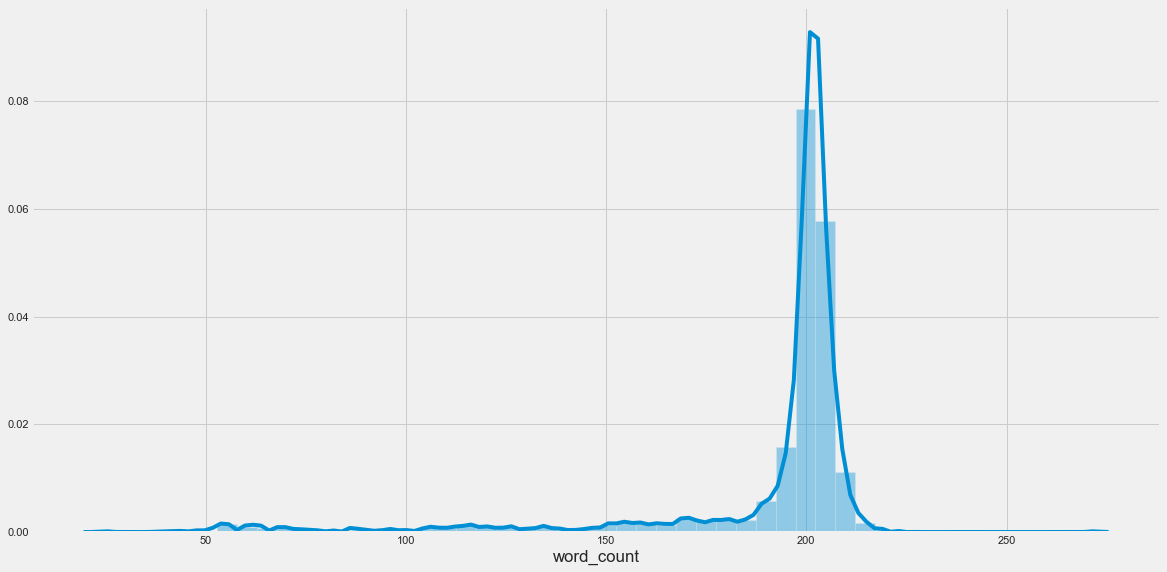

In [301]:
sns.distplot(split_df["word_count"])

/Users/yuki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


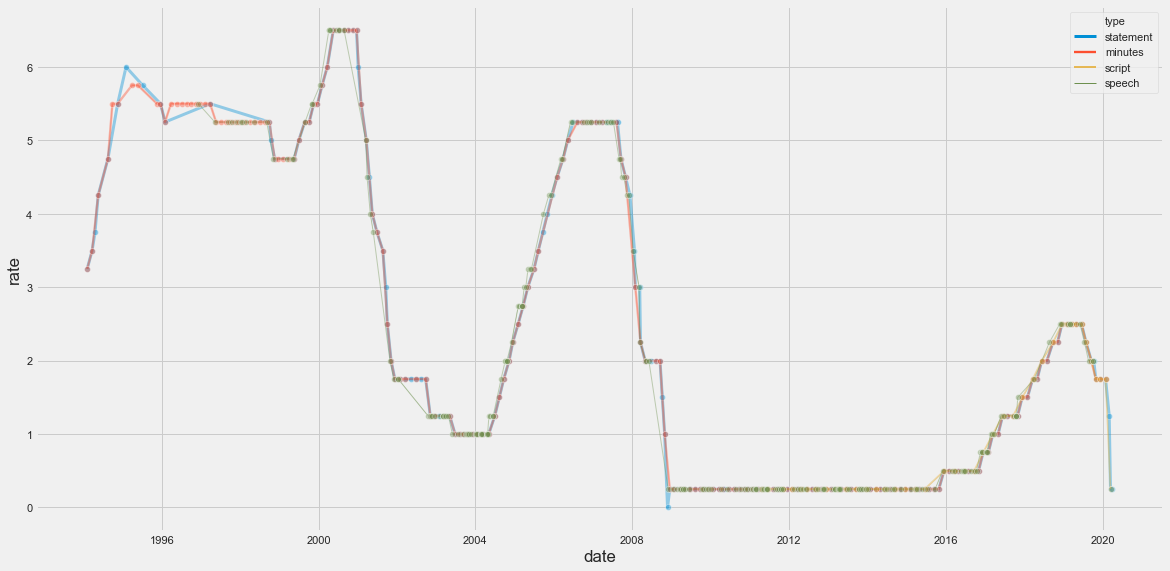

In [302]:
sns.lineplot(y=split_df["rate"].apply(lambda x: float(x)), 
             x=split_df['date'], 
             hue=split_df['type'], 
             hue_order=['statement', 'minutes', 'script', 'speech'], 
             size=split_df['type'], 
             sizes=(1, 3), 
             alpha=0.4,
             marker='o')

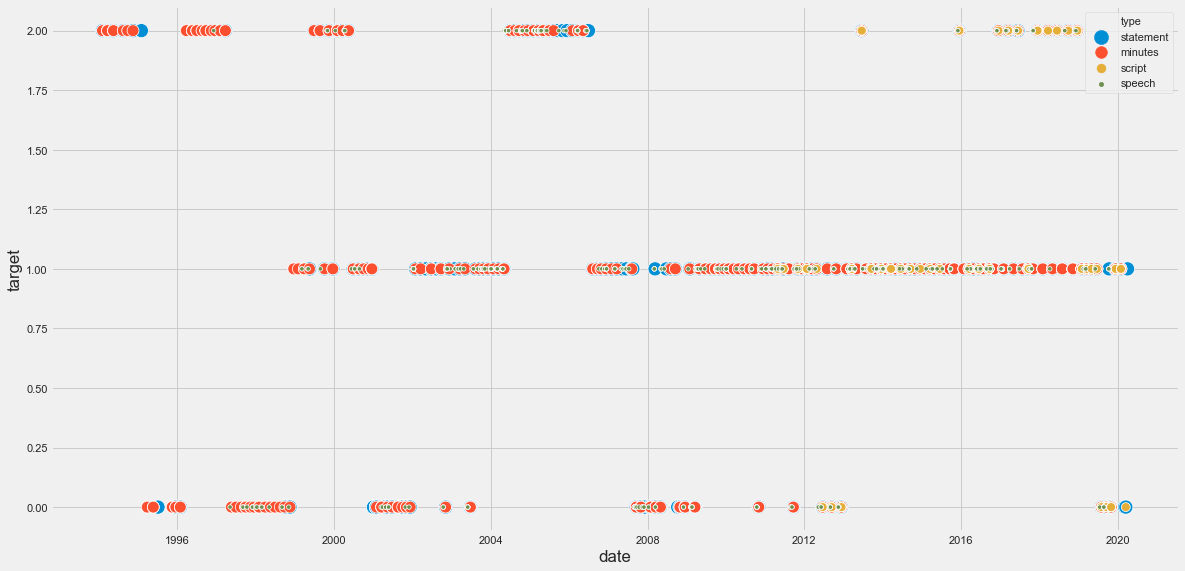

In [303]:
sns.scatterplot(y=split_df["target"].apply(lambda x: float(x)), 
                x=split_df['date'], 
                hue=split_df['type'], 
                hue_order=['statement', 'minutes', 'script', 'speech'], 
                size=split_df['type'], 
                sizes=(20, 200))

In [304]:
df

,date,rate,speaker,target,text,type,word_count,target_lower,target_hold,target_raise
0,1994-02-04,3.25,Alan Greenspan,2,he decision was taken to move toward a less accommodative stance in monetary policy in order to sustain and enhance the economic expansion.[,statement,23,0,0,1
1,1994-03-22,3.5,Alan Greenspan,2,[SECTION]Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to be asso...,statement,42,0,0,1
2,1994-04-18,3.75,Alan Greenspan,2,[SECTION]Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small ...,statement,39,0,0,1
3,1994-05-17,4.25,Alan Greenspan,2,", substantially remove the degree of monetary accommodation which prevailed throughout 1993. As always, the Federal Reserve will continue to monitor economic and financial developments to judge t...",statement,73,0,0,1
4,1994-08-16,4.75,Alan Greenspan,2,hese measures were taken against the background of evidence of continuing strength in the economic expansion and high levels of resource utilization. he Federal Reserve will continue to monitor ...,statement,105,0,0,1
5,1994-11-15,5.5,Alan Greenspan,2,"hese measures were taken against the background of evidence of persistent strength in economic activity and high and rising levels of resource utilization. n these circumstances, the Federal Res...",statement,87,0,0,1
6,1995-02-01,6,Alan Greenspan,2,"]Despite tentative signs of some moderation in growth, economic activity has continued to advance at a substantial pace, while resource utilization has risen further. n these circumstances, the ...",statement,88,0,0,1
7,1995-07-06,5.75,Alan Greenspan,0,"]As a result of the monetary tightening initiated in early 1994, inflationary pressures have receded enough to accommodate a modest adjustment in monetary conditions.[ oday's action will be refle...",statement,44,1,0,0
8,1995-12-19,5.5,Alan Greenspan,0,"ince the last easing of monetary policy in July, inflation has been somewhat more favorable than anticipated, and this result along with an associated moderation in inflation expectations warrant...",statement,59,1,0,0
9,1996-01-31,5.25,Alan Greenspan,0,"his is expected to result in a reduction in the federal funds rate of 25 basis points, from about 5-1/2percent to about 5-1/4 percent.Moderating economic expansion in recent months has reduced po...",statement,156,1,0,0
